# **Описание конкурса "Кредитный скоринг"** от **ШИФТ**

Организатором конкурса предоставлено два датасета: один тренировочный (с целевой переменной), и один тестовый – без целевой переменной.

Данные представляют собой более миллиона записей с более чем 100 признаками и одной целевой переменной: «итоговый_статус_займа». Значения: 0 – выплачен, 1 – не выплачен.

# **Постановка задачи**

Задача – обучить классификатор, наилучшим образом предсказывающий целевую переменную, чтобы помочь банку в принятии решения о выдаче займа клиентам.

Истинные значения целевой переменной известны только организаторам конкурса. Решения проверяются автоматически путем сопоставления с истинными значениями на площадке Codabench.

Метрика соревнования – roc-auc.

# EDA (Exploratory Data Analysis)

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [2]:
# загрузка библиотек

import pandas as pd
import numpy as np
import gc
import sys
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from scipy.stats import chi2_contingency
from catboost import CatBoostClassifier, Pool

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# загрузка данных

train = pd.read_csv('/content/shift_ml_2025_train.csv')
test = pd.read_csv('/content/shift_ml_2025_test.csv')

/tmp/ipython-input-1693262893.py:3: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/shift_ml_2025_train.csv')


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
train.head()

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,итоговый_статус_займа,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.0,3 года,11.99,41014.0,В,В1,инженер,10+ лет,ИПОТЕКА,1300000.0,Не подтвержден,0,4,n,0.899168,мелкий_бизнес,0,577.0,Новгородская область,16.06,Нет,Нет,1.0,1.345312e+06,0.767016,12-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,а,0.0,0.0,False,NaN,5,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,12213,10219800.0,1.0,1.0,0.0,1.0,19.0,900250.0,73.0,2.0,3.0,6472.0,29.0,5590000.0,0.0,0.0,6.0,4.0,486650.0,2891500.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,15700850.0,1973750.0,3965000.0,1233350.0,NaN,Нет,Наличные
1,68341763,1000000.0,5 лет,10.78,21633.0,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,1260000.0,Не подтвержден,0,2,n,0.489891,улучшение_жилищных_условий,0,605.0,Республика Татарстан,10.78,Нет,Нет,0.0,1.345312e+06,0.229990,8-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,а,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Совместный,3550000.0,13.85,Не подтвержден,0.0,0.0,36245,9484950.0,0.0,1.0,0.0,4.0,19.0,541350.0,73.0,0.0,2.0,2

In [7]:
test.head()

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,85540387,450000.0,3 года,9.49,14413.0,Б,Б2,обслуживание клиентов,10+ лет,ИПОТЕКА,840000.0,Не подтвержден,4,n,0.458947,консолидация_долга,0,601.0,Республика Татарстан,19.09,Нет,Да,0.0,1.345312e+06,0.812613,6-1995,740.0,744.0,0.0,NaN,NaN,11.0,0.0,7735.0,34.1,20.0,а,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,92843,3111700.0,0.0,2.0,1.0,2.0,10.0,793850.0,78.0,0.0,1.0,2594.0,55.0,1135000.0,1.0,1.0,2.0,3.0,282900.0,395700.0,45.4,0.0,0.0,112.0,253.0,17.0,10.0,2.0,17.0,NaN,10.0,NaN,0.0,3.0,5.0,4.0,6.0,7.0,8.0,11.0,5.0,11.0,0.0,0.0,0.0,1.0,100.0,75.0,0.0,0.0,4282850.0,1180600.0,725000.0,1022000.0,NaN,Нет,Наличные
1,28112500,400000.0,3 года,6.03,12174.5,А,А1,помощник по правовым вопросам,5 лет,АРЕНДА,1520000.0,Не подтвержден,4,n,0.006964,консолидация_долга,0,112.0,Новосибирская область,20.42,Нет,Нет,0.0,1.345312e+06,0.725167,12-1997,710.0,714.0,0.0,NaN,NaN,14.0,0.0,23650.0,78.6,28.0,б,0.0,0.0,NaN,NaN,1,0.0,NaN,1.0,Индивидуальный,NaN,NaN,NaN,0.0,0.0,43004,2381050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505000.0,NaN,NaN,NaN,1.0,18

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(19)
memory usage: 1006.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Columns: 108 entries, id to тип_предоставления_кредита
dtypes: float64(85), int64(5), object(18)
memory usage: 110.9+ MB


In [10]:
# баланс классов целевой переменной

train['итоговый_статус_займа'].value_counts()

,count
итоговый_статус_займа,
0,969085
1,241694


Обнаружен дисбаланас классов целевой переменной.

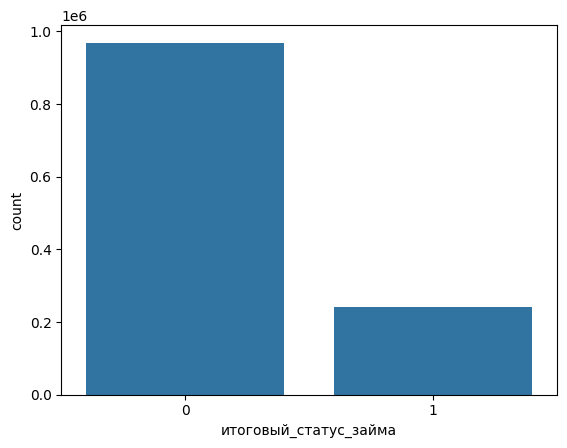

In [11]:
# визуализация распределения классов целевого признака

sns.countplot(data=train, x='итоговый_статус_займа')
plt.xticks()
plt.show();

In [12]:
# количество признаков по типам данных в train

train_type_dict = defaultdict(list)

for col in train.columns:
    dtype = str(train[col].dtype)
    train_type_dict[dtype].append(col)

print('Детализация по типам данных:')
for dtype, columns in train_type_dict.items():
    print(f'\nТип: {dtype} ({len(columns)} признаков)')
    print('Примеры:', columns[:6])

Детализация по типам данных:

Тип: int64 (6 признаков)
Примеры: ['id', 'итоговый_статус_займа', 'рейтинг_OCR', 'кол_во_субсидий_за_год', 'грейд_на_детерминаторе', 'возвраты_с_учетом_мпл']

Тип: float64 (84 признаков)
Примеры: ['сумма_займа', 'процентная_ставка', 'аннуитет', 'годовой_доход', 'коэфф_акционных_зачислений_в_остатке', 'индекс_проживания']

Тип: object (19 признаков)
Примеры: ['срок_займа', 'рейтинг', 'допрейтинг', 'профессия_заемщика', 'стаж', 'владение_жильем']


In [13]:
# количество признаков по типам данных в test

test_type_dict = defaultdict(list)

for col in test.columns:
    dtype = str(test[col].dtype)
    test_type_dict[dtype].append(col)

print('Детализация по типам данных:')
for dtype, columns in test_type_dict.items():
    print(f'\nТип: {dtype} ({len(columns)} признаков)')
    print('Примеры:', columns[:6])

Детализация по типам данных:

Тип: int64 (5 признаков)
Примеры: ['id', 'рейтинг_OCR', 'кол_во_субсидий_за_год', 'грейд_на_детерминаторе', 'возвраты_с_учетом_мпл']

Тип: float64 (85 признаков)
Примеры: ['сумма_займа', 'процентная_ставка', 'аннуитет', 'годовой_доход', 'коэфф_акционных_зачислений_в_остатке', 'индекс_проживания']

Тип: object (18 признаков)
Примеры: ['срок_займа', 'рейтинг', 'допрейтинг', 'профессия_заемщика', 'стаж', 'владение_жильем']


Видим разницу в количестве признаков с типами float64 и object в train и test (помимо отсутствующего столбца с целевым признаком в int64)

In [14]:
# находим расхождения в типах данных у признаков в train и test

train_dtypes = train.dtypes
test_dtypes = test.dtypes

dtype_comparison = pd.DataFrame({
    'train_dtype': train_dtypes,
    'test_dtype': test_dtypes
})

mismatched_types = dtype_comparison[dtype_comparison['train_dtype'] != dtype_comparison['test_dtype']]

display(mismatched_types)

,train_dtype,test_dtype
итоговый_статус_займа,int64,NaN
пени_за_дефолт,object,float64


In [15]:
# баланс классов признака 'пени_за_дефолт' в train

train['пени_за_дефолт'].value_counts()

,count
пени_за_дефолт,
False,735956
True,111382


In [16]:
# баланс классов признака 'пени_за_дефолт' в test

test['пени_за_дефолт'].value_counts()

,count
пени_за_дефолт,


В train признак 'пени_за_дефолт' имеет тип object и 2 уникальных значения - True/False с выраженным дисбалансом, а также пропуски NaN. В test выборке значения признака вообще отсутствуют, столбец заполнен NaN (тип float64).

In [17]:
# типы данных в признаках с подсчетом пропущенных, уникальных, бесконечных, отрицательных значений, дубликатов
# для train

meta_info = pd.DataFrame({
    'data_type': train.dtypes,
    'missing_values': train.isnull().sum(),
    'unique_values': train.nunique(),
    'inf_values': train.apply(lambda col: np.isinf(col).sum() if np.issubdtype(col.dtype, np.number) else 0),
    'negative_values': train.apply(lambda col: (col < 0).sum() if np.issubdtype(col.dtype, np.number) else 0),
    'duplicates': train.duplicated().sum()
})

with pd.option_context('display.max_rows', None):
    display(meta_info)

,data_type,missing_values,unique_values,inf_values,negative_values,duplicates
id,int64,0,1210779,0,0,0
сумма_займа,float64,0,1551,0,0,0
срок_займа,object,0,2,0,0,0
процентная_ставка,float64,0,650,0,0,0
аннуитет,float64,0,81156,0,0,0
рейтинг,object,0,7,0,0,0
допрейтинг,object,0,35,0,0,0
профессия_заемщика,object,77049,273666,0,0,0
стаж,object,70508,11,0,0,0
владение_жильем,object,0,6,0,0,0


Дубликатов и бесконечных значений нет. Очень много пропусков. Есть одно отрицательное значение в 'пдн' и три в 'сумма_выплат_по_просрочкам'.

In [18]:
# проанализируем пропуски в train

missing_analysis = pd.DataFrame({
    'missing_count': train.isnull().sum(),
    'missing_percent': train.isnull().mean() * 100
})

# топ-30 признаков по количеству пропущенных значений в train
top_missing = missing_analysis.sort_values('missing_count', ascending=False).head(30)

pd.options.display.float_format = '{:.2f}'.format
print('Топ-30 признаков по количеству пропущенных значений:')
display(top_missing.style.format({'missing_percent': '{:.2f}%'}))

Топ-30 признаков по количеству пропущенных значений:


,missing_count,missing_percent
дата_следующей_выплаты,1210779,100.00%
кредитный_баланс_по_возоб_счетам,1193971,98.61%
совокупный_статус_подтверждения_доходов_заемщиков,1187729,98.10%
совокупный_пдн_заемщиков,1187548,98.08%
совокупный_доход_заемщиков,1187546,98.08%
кол-во_месяцев_с_последнего_займа,1005117,83.01%
кол-во_мес_с_последней_задолженности_по_карте,923517,76.27%
кол-во_месяцев_с_последнего_нарушения,892120,73.68%
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,805599,66.54%
соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,792391,65.44%


In [19]:
# типы данных в признаках с подсчетом пропущенных, уникальных, бесконечных, отрицательных значений, дубликатов
# для test

meta_info_test = pd.DataFrame({
    'data_type': test.dtypes,
    'missing_values': test.isnull().sum(),
    'unique_values': test.nunique(),
    'inf_values': test.apply(lambda col: np.isinf(col).sum() if np.issubdtype(col.dtype, np.number) else 0),
    'negative_values': test.apply(lambda col: (col < 0).sum() if np.issubdtype(col.dtype, np.number) else 0),
    'duplicates': test.duplicated().sum()
})

with pd.option_context('display.max_rows', None):
    display(meta_info_test)

,data_type,missing_values,unique_values,inf_values,negative_values,duplicates
id,int64,0,134531,0,0,0
сумма_займа,float64,0,1410,0,0,0
срок_займа,object,0,2,0,0,0
процентная_ставка,float64,0,579,0,0,0
аннуитет,float64,0,34195,0,0,0
рейтинг,object,0,7,0,0,0
допрейтинг,object,0,35,0,0,0
профессия_заемщика,object,8736,46727,0,0,0
стаж,object,8003,11,0,0,0
владение_жильем,object,0,6,0,0,0


Аналогично train в test нет дубликатов и бесконечных значений, но много пропусков. Есть одно отрицательное значение в 'пдн' и одно в 'сумма_выплат_по_просрочкам'.

In [20]:
# проанализируем пропуски в test

missing_analysis_test = pd.DataFrame({
    'missing_count': test.isnull().sum(),
    'missing_percent': test.isnull().mean() * 100
})

# топ-30 признаков по количеству пропущенных значений в test
top_missing_test = missing_analysis_test.sort_values('missing_count', ascending=False).head(30)

pd.options.display.float_format = '{:.2f}'.format
print('Топ-30 признаков по количеству пропущенных значений:')
display(top_missing_test.style.format({'missing_percent': '{:.2f}%'}))

Топ-30 признаков по количеству пропущенных значений:


,missing_count,missing_percent
дата_следующей_выплаты,134531,100.00%
пени_за_дефолт,134531,100.00%
кредитный_баланс_по_возоб_счетам,132710,98.65%
совокупный_статус_подтверждения_доходов_заемщиков,131986,98.11%
совокупный_пдн_заемщиков,131965,98.09%
совокупный_доход_заемщиков,131964,98.09%
кол-во_месяцев_с_последнего_займа,111638,82.98%
кол-во_мес_с_последней_задолженности_по_карте,102773,76.39%
кол-во_месяцев_с_последнего_нарушения,99440,73.92%
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,89749,66.71%


In [21]:
# основные статистики численных признаков в train

display(train.describe(include=[np.number]))

,id,сумма_займа,процентная_ставка,аннуитет,годовой_доход,итоговый_статус_займа,рейтинг_OCR,коэфф_акционных_зачислений_в_остатке,кол_во_субсидий_за_год,индекс_проживания,пдн,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам
count,1210779.00,1210779.00,1210779.00,1210779.00,1210779.00,1210779.00,1210779.00,1210779.00,1210779.00,1210778.00,1210441.00,1210779.00,1210779.00,1210779.00,1210779.00,1210779.00,1210778.00,600218.00,205662.00,1210779.00,1210779.00,1210779.00,1210010.00,1210779.00,1210779.00,1210779.00,0.00,1210779.00,1210732.00,318659.00,1210779.00,23233.00,23231.00,1210779.00,1150012.00,1210779.00,1150012.00,483877.00,483878.00,483878.00,483878.00,471070.00,483878.00,418388.00,483878.00,483878.00,483878.00,483827.00,1150012.00,483878.00,483877.00,483877.00,1168297.00,1149991.00,1155808.00,1155116.00,1210732.00,1210779.00,1115759.00,1150011.00,1150011.00,1150012.00,1168297.00,1156649.00,287262.00,1054242.00,405180.00,1150012.00,1150012.00,1150012.00,1160572.00,1150012.00,1150012.00,1150012.00,1150011.00,1150012.00,1160572.00,1105262.00,1150012.00,1150012.00,1150012.00,1149877.00,1155448.00,1210161.00,1210745.00,1150012.00,1168297.00,1168297.00,1150012.00,16808.00
mean,56343005.31,721035.23,13.24,21904.78,1525304.28,0.20,2.50,0.50,0.30,515.56,18.29,0.32,1345311.54,0.50,696.18,700.18,0.66,34.31,70.63,11.60,0.22,16254.90,51.80,24.98,0.00,79.30,NaN,3.00,0.02,43.70,1.00,5869318.02,18.88,0.01,250.87,54972.62,7060188.84,1.05,2.79,0.78,1.74,19.60,1793878.29,71.44,1.42,3.01,5539.22,58.17,1640264.30,1.09,1.61,2.31,4.69,674552.48,509743.40,59.93,0.01,761.24,125.78,181.49

In [22]:
# отрицательные значения в train

anomalies = train[(train['сумма_выплат_по_просрочкам'] < 0) | (train['пдн'] < 0)][['сумма_выплат_по_просрочкам', 'пдн']]

display(anomalies.style.format({
    'сумма_выплат_по_просрочкам': '{:.2f}',
    'пдн': '{:.2f}'
}))

,сумма_выплат_по_просрочкам,пдн
20852,-0.00,52.45
300686,-0.00,26.10
415902,-0.00,18.38
872785,0.00,-1.00


Очень странные значения с минусом. Так как мы не знаем природы этих отрицательных значений и их всего 4 строки, поэтому исправим на 0.

In [23]:
# заменим отрицательные значения в train на 0

cols = ['сумма_выплат_по_просрочкам', 'пдн']

for col in cols:
    train.loc[train[col] < 0, col] = 0

In [24]:
# основные статистики численных признаков в test

display(test.describe(include=[np.number]))

,id,сумма_займа,процентная_ставка,аннуитет,годовой_доход,рейтинг_OCR,коэфф_акционных_зачислений_в_остатке,кол_во_субсидий_за_год,индекс_проживания,пдн,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам
count,134531.00,134531.00,134531.00,134531.00,134531.00,134531.00,134531.00,134531.00,134531.00,134495.00,134531.00,134531.00,134531.00,134531.00,134531.00,134531.00,66349.00,22893.00,134531.00,134531.00,134531.00,134443.00,134531.00,134531.00,134531.00,0.00,0.00,134531.00,134522.00,35091.00,134531.00,2567.00,2566.00,134531.00,127771.00,134531.00,127771.00,53720.00,53720.00,53720.00,53720.00,52312.00,53720.00,46628.00,53720.00,53720.00,53720.00,53718.00,127771.00,53720.00,53720.00,53720.00,129732.00,127770.00,128359.00,128282.00,134522.00,134531.00,123976.00,127771.00,127771.00,127771.00,129732.00,128440.00,31758.00,116997.00,44782.00,127771.00,127771.00,127771.00,128897.00,127771.00,127771.00,127771.00,127771.00,127771.00,128897.00,122647.00,127771.00,127771.00,127771.00,127752.00,128307.00,134452.00,134526.00,127771.00,129732.00,129732.00,127771.00,1821.00
mean,56362892.92,720668.96,13.24,21894.75,1521788.78,2.50,0.50,0.30,515.21,18.25,0.32,1345311.54,0.50,696.26,700.26,0.65,34.32,70.69,11.56,0.21,16187.02,51.86,24.95,0.00,77.79,NaN,NaN,3.00,0.02,43.70,1.00,5867625.46,19.04,0.00,236.06,55048.12,7025174.98,1.05,2.79,0.77,1.74,19.51,1786094.69,71.30,1.43,3.00,5524.07,58.22,1633089.45,1.10,1.61,2.32,4.68,673332.57,505424.58,60.05,0.01,596.60,125.98,181.31,13.12,7.85,1.67,23.75,39.75,6.72,35.83,0.51,3.63,5.62,4.72,8.08,8.58,8.24,14.57,5.57,11.61,0.00,0.00,

In [25]:
# уникальные значения в столбце 'индекс_проживания'

train['индекс_проживания'].unique()

array([577., 605., 300., 550., 293., 160.,  29., 275., 916., 299., 226.,
       856., 462., 219., 297., 100., 214., 750., 672., 125., 880., 238.,
       354., 114., 993., 212., 215., 710., 606., 331., 802., 761., 142.,
       493., 330., 441., 644., 471., 200.,  15., 453.,  19., 347., 546.,
       351., 852., 210., 134., 112., 440., 430., 967., 958., 472.,  85.,
       117., 774., 787., 447., 752., 434., 670.,  16., 381., 236., 850.,
       482.,  70.,  30., 220.,  23., 280., 436., 604., 660., 681., 439.,
       431., 973., 477., 377., 301., 349., 282., 986., 910., 544., 136.,
       197., 355., 207., 448., 913., 551., 498.,  10.,  64., 481., 211.,
        88., 334., 327., 111., 926., 805., 138., 930., 770., 725., 322.,
       751., 206., 113., 234., 894., 146., 250.,  80.,  31.,  28., 208.,
       594., 945.,  38., 941., 346., 191., 922., 906., 104., 158., 900.,
       294., 957., 490., 370.,  20., 800.,  82., 563., 786., 463., 607.,
       164., 980., 956., 231., 324., 773., 600., 34

Значения индексов одно-, двух- и трехзначные, что очень странно. На регион указывают первые 3 цифры индекса. Можно было бы для обучения  модели удалить столбец 'регион', потому что там больше пропусков. Но неполные индексы тоже не вариант. Для анализа же человеку проще использовать столбец 'регион'.

In [26]:
# отрицательные значения в test

anomalies = test[(test['сумма_выплат_по_просрочкам'] < 0) | (test['пдн'] < 0)][['сумма_выплат_по_просрочкам', 'пдн']]

display(anomalies.style.format({
    'сумма_выплат_по_просрочкам': '{:.2f}',
    'пдн': '{:.2f}'
}))

,сумма_выплат_по_просрочкам,пдн
61834,-0.00,20.30
108014,0.00,-1.00


Аналогично как и в train в test найдены отрицательные значения в тех же столбцах - 'сумма_выплат_по_просрочкам' и 'пдн'.

In [27]:
# заменим отрицательные значения на 0

cols = ['сумма_выплат_по_просрочкам', 'пдн']

for col in cols:
    test.loc[test[col] < 0, col] = 0

In [28]:
# статистики категориальных данных в train

display(train.describe(include=[object]))

,срок_займа,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,подтвержден_ли_доход,платежный_график,цель_займа,регион,пос_стоп_фактор,юридический_статус,дата_первого_займа,первоначальный_статус_займа,пени_за_дефолт,тип_займа,совокупный_статус_подтверждения_доходов_заемщиков,особая_ситуация,тип_предоставления_кредита
count,1210779,1210779,1210779,1133730,1140271,1210779,1210779,1210779,1210779,1210779,1210779,1210779,1210779,1210779,847338,1210779,23050,1210779,1210779
unique,2,7,35,273666,11,6,3,1,14,51,3,2,738,2,2,2,3,1,2
top,3 года,Б,В1,менеджер,10+ лет,ИПОТЕКА,Подтвержден источник,n,консолидация_долга,Московская область,Нет,Нет,8-2001,а,False,Индивидуальный,Не подтвержден,Нет,Наличные
freq,918586,353530,76885,23291,398214,598993,468878,1210779,702475,177023,1089579,968854,8407,705688,735956,1187546,13380,1210779,1204573


По факту среди категориальных признаков можно выделить 6 бинарных. Некоторые категории можно обработать и/или перевести в числовые. Некоторые признаки заполнены одним-единственным значением ('платежный_график' и 'особая_ситуация')

In [29]:
# посмотрим подробнее на уникальные значения-категории в train

cat_cols = train.select_dtypes(include=['object']).columns

unique_categories = {col: train[col].unique() for col in cat_cols}

for col, values in unique_categories.items():
    print(f'\nСтолбец: {col}')
    print(f'Количество уникальных значений: {len(values)}')
    print('Уникальные категории:', values[:10])  # первые 10
    if len(values) > 10:
        print(f' и еще {len(values)-10} значений')


Столбец: срок_займа
Количество уникальных значений: 2
Уникальные категории: ['3 года' '5 лет']

Столбец: рейтинг
Количество уникальных значений: 7
Уникальные категории: ['В' 'Б' 'А' 'Д' 'Г' 'Е' 'Ж']

Столбец: допрейтинг
Количество уникальных значений: 35
Уникальные категории: ['В1' 'Б4' 'В3' 'Б2' 'Б1' 'А2' 'Б5' 'В2' 'Д2' 'А4']
 и еще 25 значений

Столбец: профессия_заемщика
Количество уникальных значений: 273667
Уникальные категории: ['инженер' 'водитель грузовика' 'ветеринарный техник'
 'вице-президент операций по набору персонала' 'дорожному водителю'
 'управление услугами' 'связь с поставщиками'
 'руководитель материально-технического обеспечения'
 'менеджер программного обеспечения' 'старший руководитель']
 и еще 273657 значений

Столбец: стаж
Количество уникальных значений: 12
Уникальные категории: ['10+ лет' '4 года' '6 лет' '3 года' '7 лет' '8 лет' '2 года' '5 лет'
 '9 лет' '< 1 года']
 и еще 2 значений

Столбец: владение_жильем
Количество уникальных значений: 6
Уникальные кате

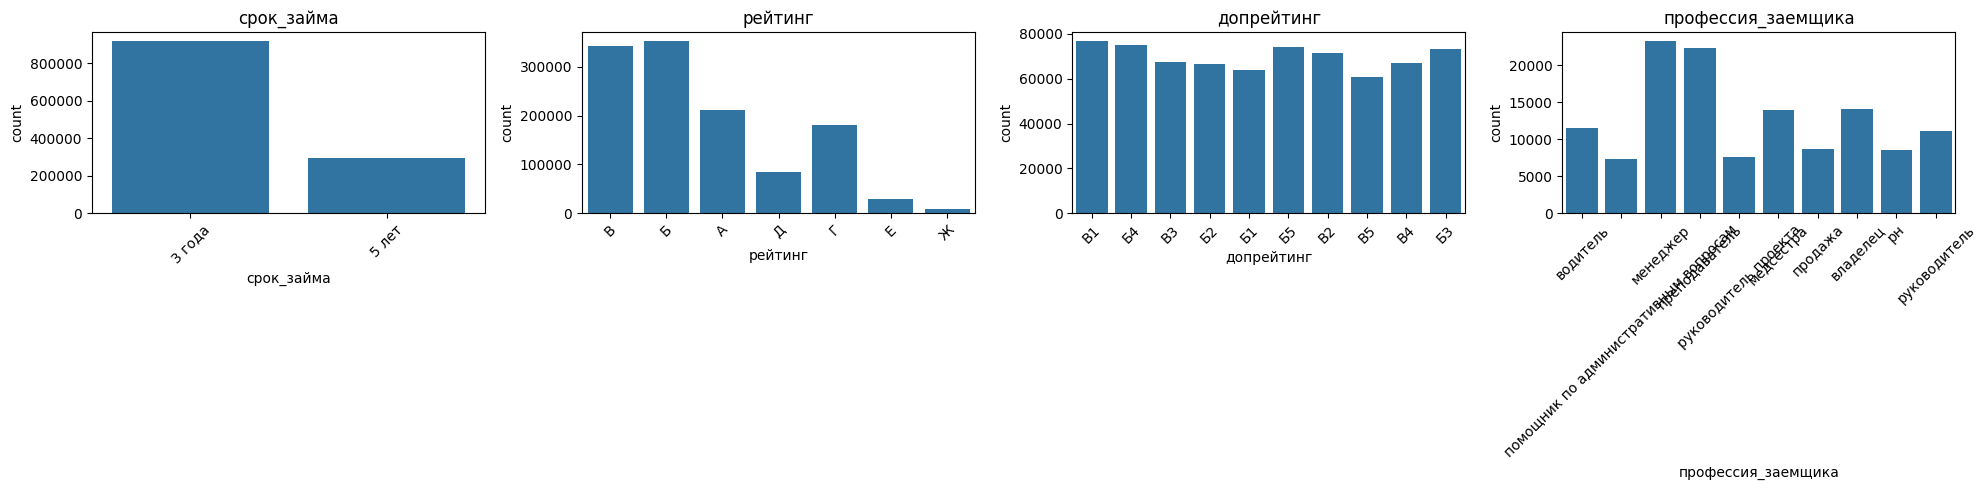

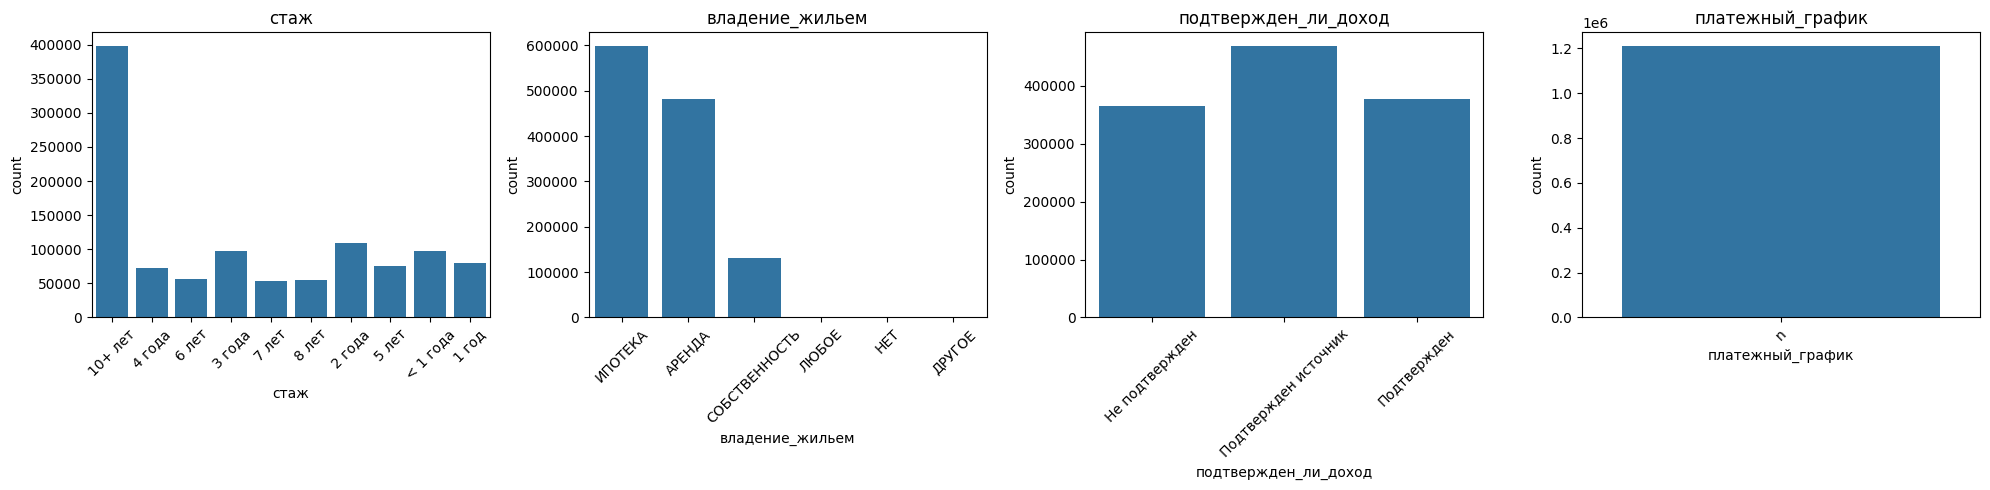

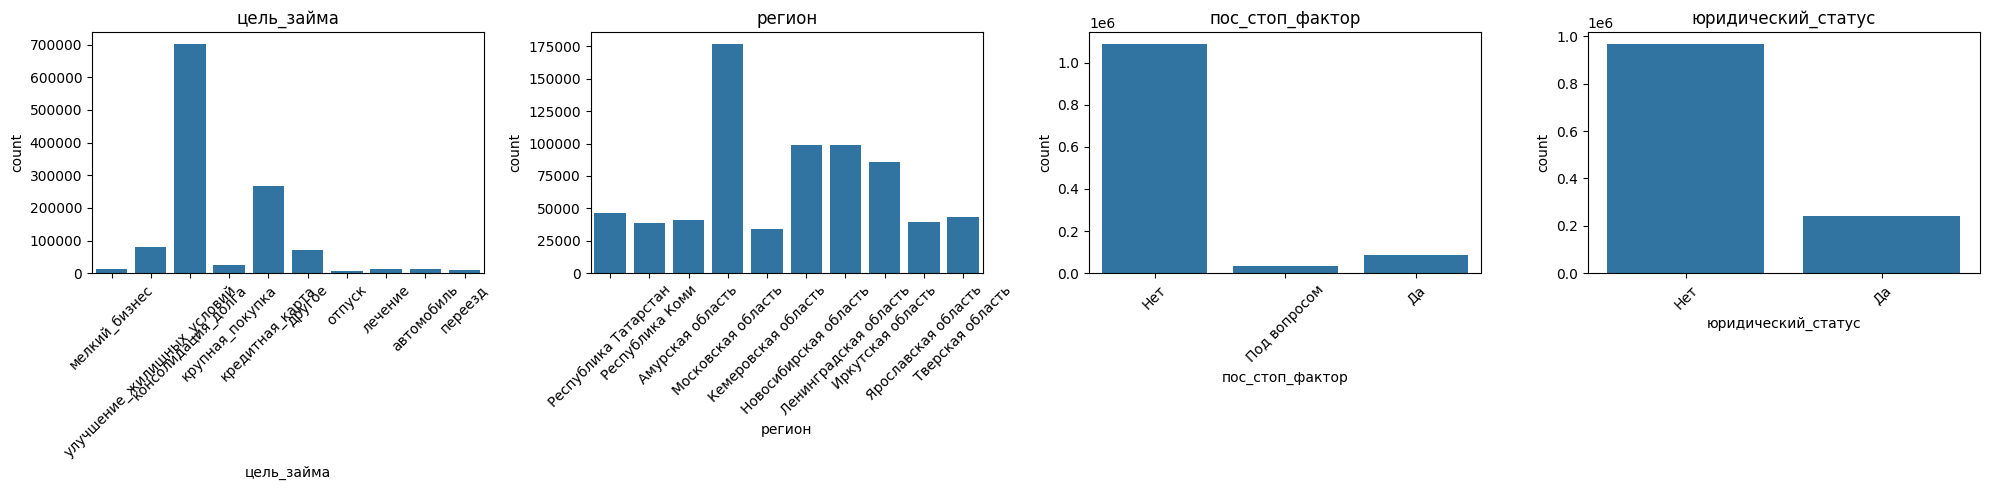

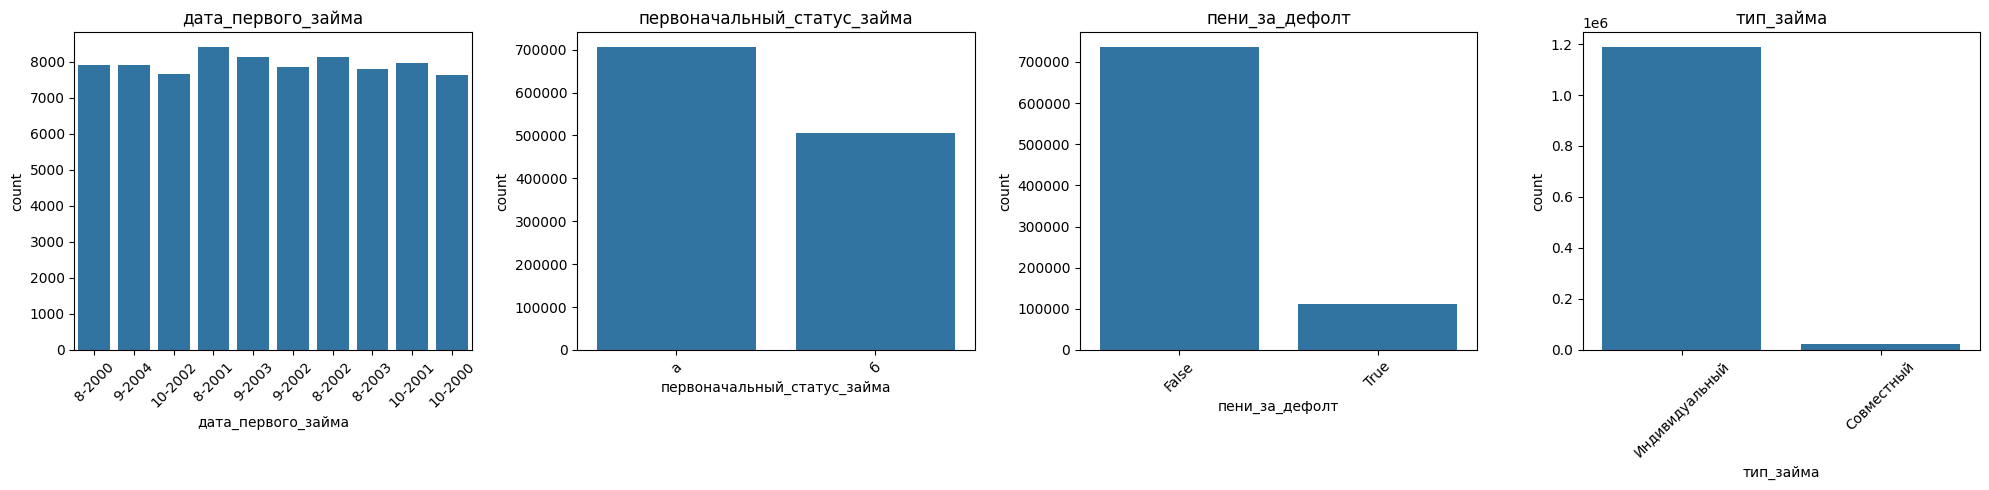

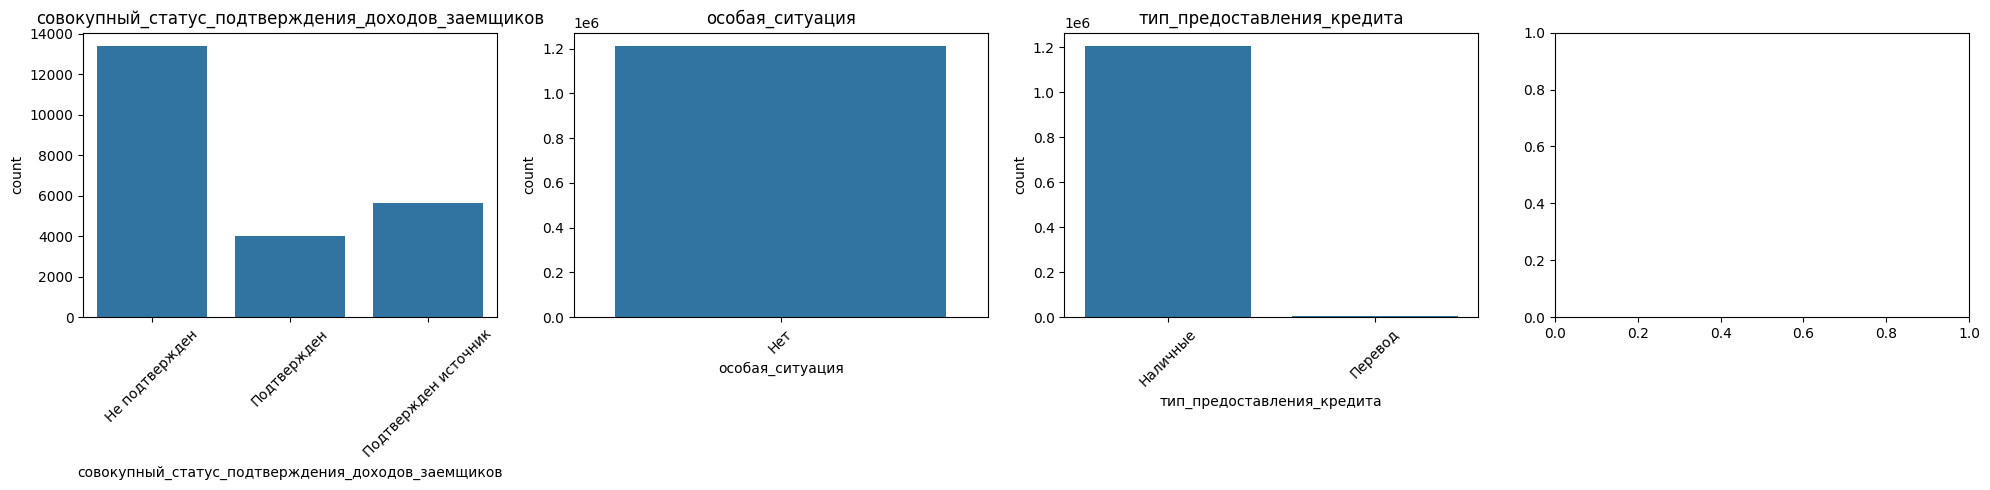

In [30]:
# посмотрим на распределения категориальных признаков в train

for i in range(0, len(cat_cols), 4):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    batch = cat_cols[i:i+4]

    for j, col in enumerate(batch):
        # топ-10 самых частых значений
        top_cats = train[col].value_counts().nlargest(10).index
        filtered_data = train[train[col].isin(top_cats)]

        sns.countplot(data=filtered_data, x=col, ax=axes[j])
        axes[j].set_title(col, fontsize=12)
        axes[j].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

    del fig, axes, batch, filtered_data  # удаляем переменные
    gc.collect()  # собираем мусор

In [31]:
# статистики категориальных данных в test

display(test.describe(include=[object]))

,срок_займа,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,подтвержден_ли_доход,платежный_график,цель_займа,регион,пос_стоп_фактор,юридический_статус,дата_первого_займа,первоначальный_статус_займа,тип_займа,совокупный_статус_подтверждения_доходов_заемщиков,особая_ситуация,тип_предоставления_кредита
count,134531,134531,134531,125795,126528,134531,134531,134531,134531,134531,134531,134531,134531,134531,134531,2545,134531,134531
unique,2,7,35,46727,11,6,3,1,14,50,3,2,663,2,2,3,1,2
top,3 года,Б,В1,менеджер,10+ лет,ИПОТЕКА,Подтвержден источник,n,консолидация_долга,Московская область,Нет,Нет,8-2001,а,Индивидуальный,Не подтвержден,Нет,Наличные
freq,102157,39211,8609,2518,43985,66586,52395,134531,77846,19505,120885,107737,984,78322,131964,1492,134531,133837


In [32]:
# посмотрим подробнее на уникальные значения-категории в test

cat_cols = test.select_dtypes(include=['object']).columns

unique_categories = {col: test[col].unique() for col in cat_cols}

for col, values in unique_categories.items():
    print(f'\nСтолбец: {col}')
    print(f'Количество уникальных значений: {len(values)}')
    print('Уникальные категории:', values[:10])  # первые 10
    if len(values) > 10:
        print(f' и еще {len(values)-10} значений')


Столбец: срок_займа
Количество уникальных значений: 2
Уникальные категории: ['3 года' '5 лет']

Столбец: рейтинг
Количество уникальных значений: 7
Уникальные категории: ['Б' 'А' 'В' 'Д' 'Г' 'Е' 'Ж']

Столбец: допрейтинг
Количество уникальных значений: 35
Уникальные категории: ['Б2' 'А1' 'В1' 'Д5' 'Д1' 'В4' 'Б3' 'Г5' 'Г1' 'В3']
 и еще 25 значений

Столбец: профессия_заемщика
Количество уникальных значений: 46728
Уникальные категории: ['обслуживание клиентов' 'помощник по правовым вопросам'
 'специалист по анализу кредитоспособности' 'специальный специалист'
 'руководитель районного проекта' 'инженер' 'управляющий контрактом'
 'очищенные бридеры' 'видеопереводчик' nan]
 и еще 46718 значений

Столбец: стаж
Количество уникальных значений: 12
Уникальные категории: ['10+ лет' '5 лет' '3 года' '< 1 года' '1 год' nan '6 лет' '8 лет'
 '2 года' '4 года']
 и еще 2 значений

Столбец: владение_жильем
Количество уникальных значений: 6
Уникальные категории: ['ИПОТЕКА' 'АРЕНДА' 'СОБСТВЕННОСТЬ' 'ДРУГО

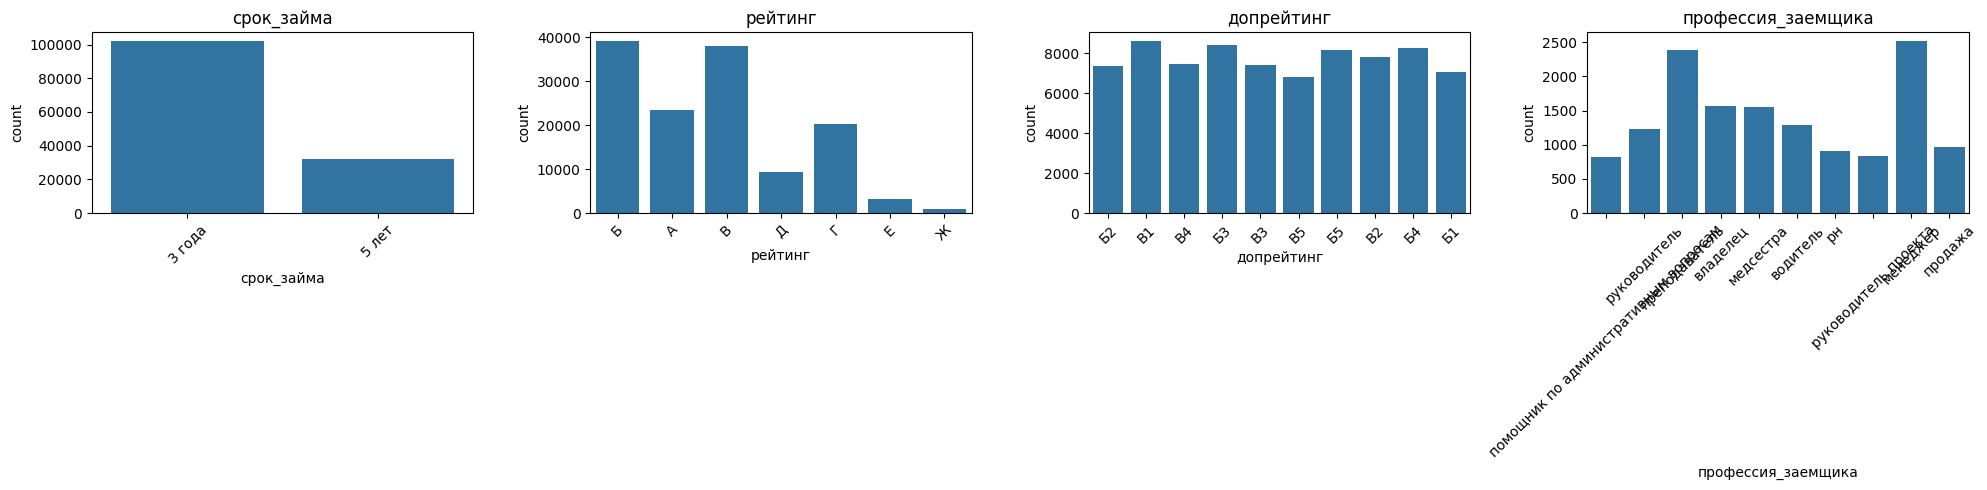

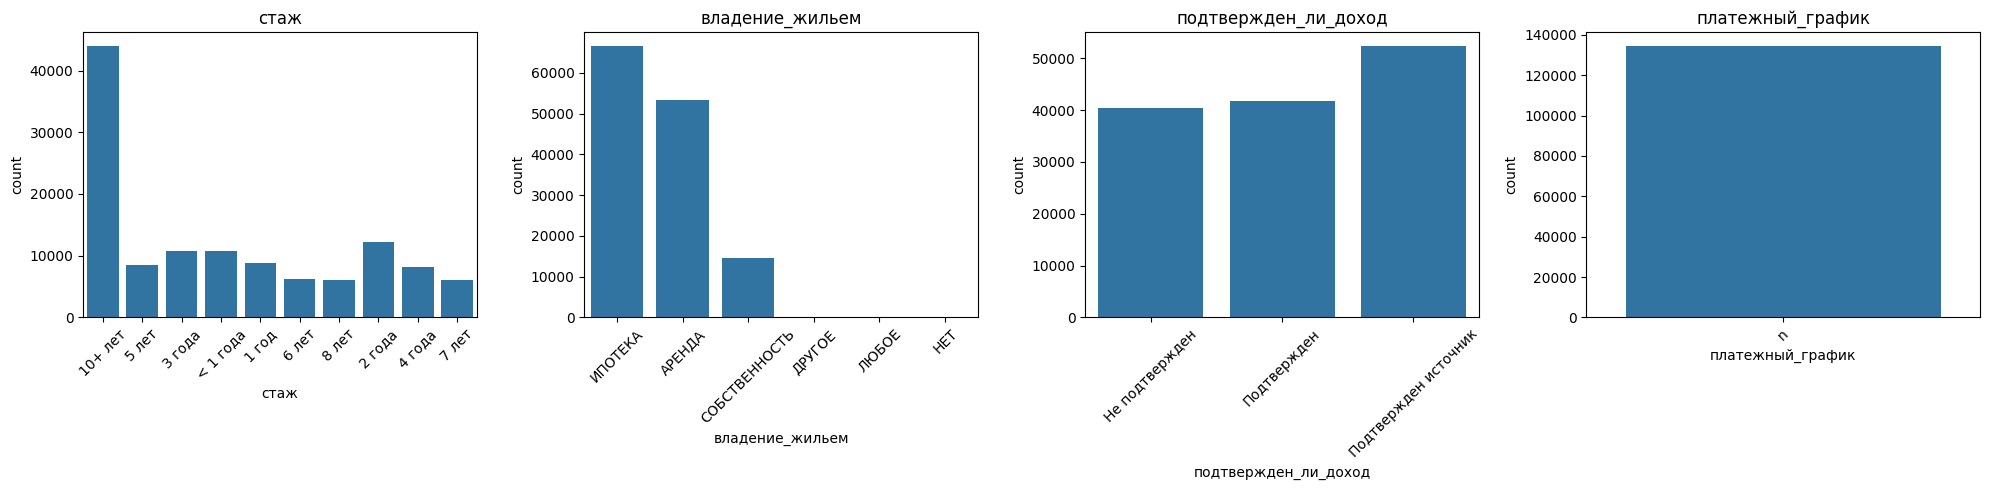

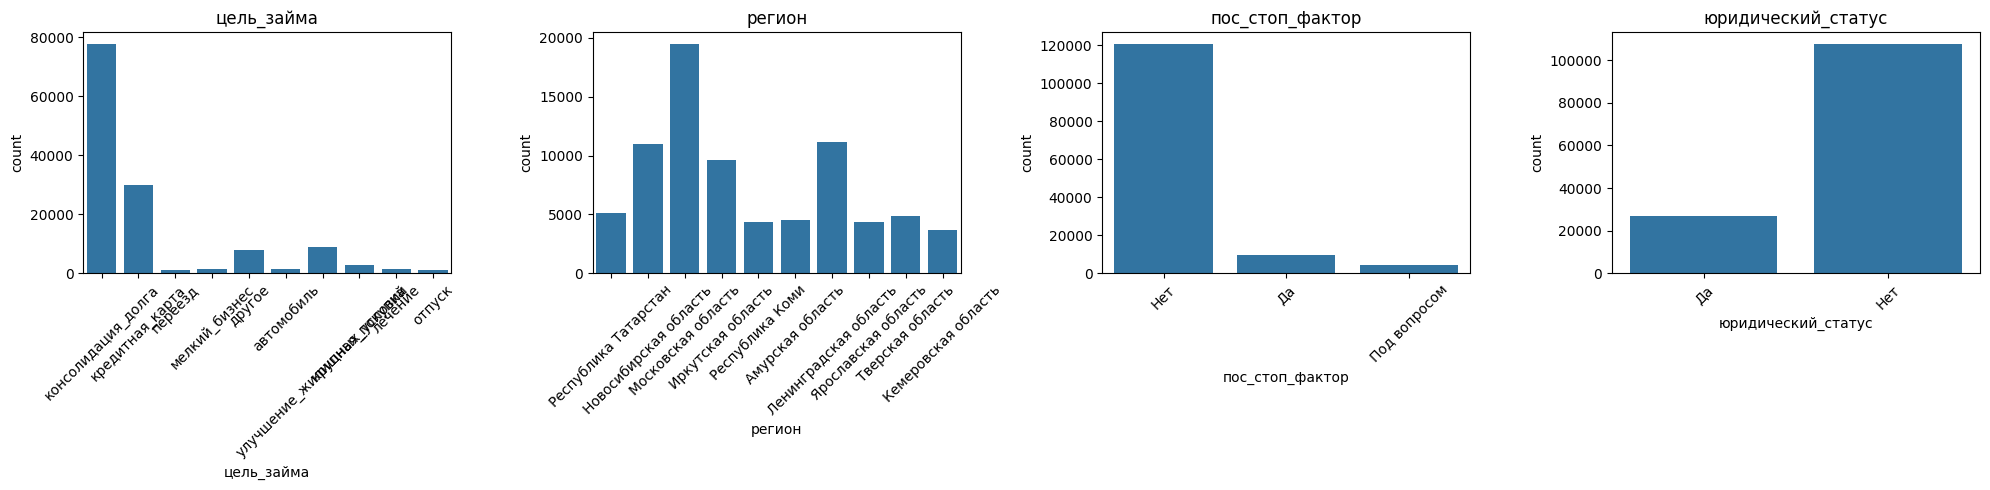

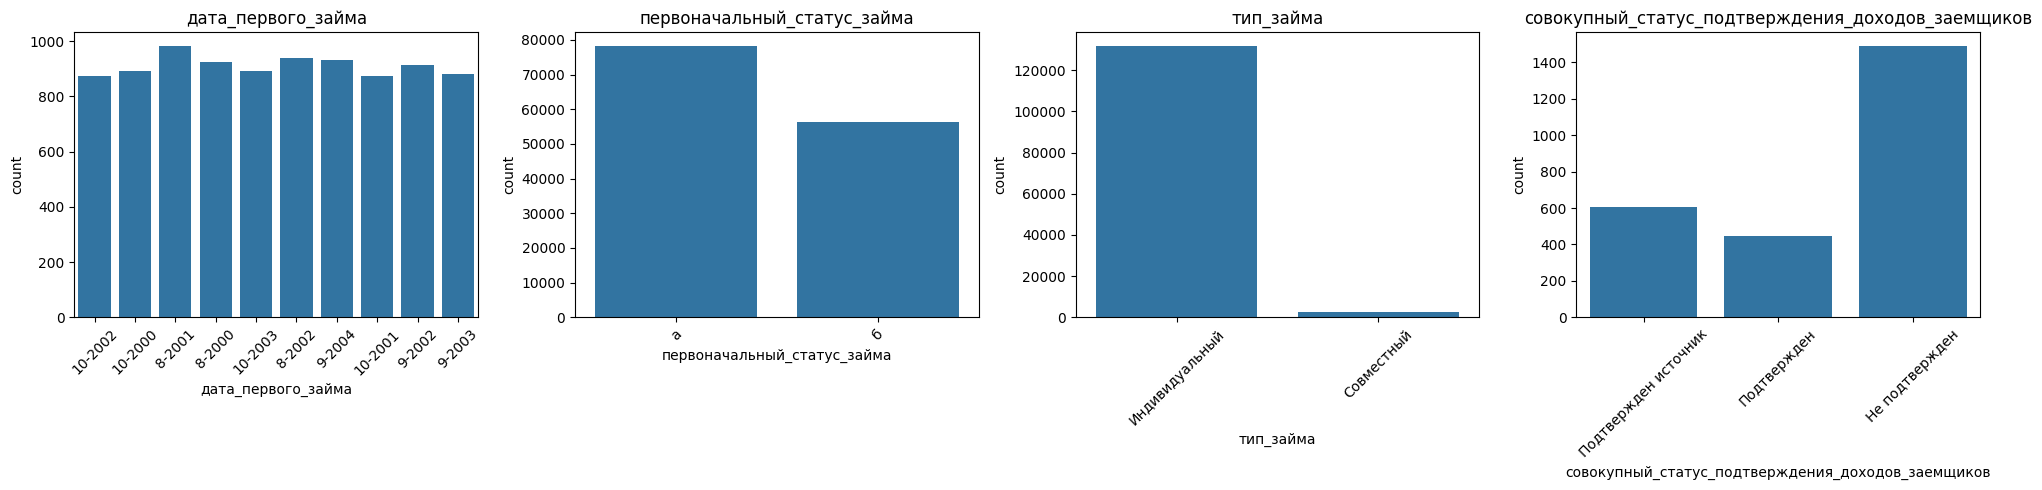

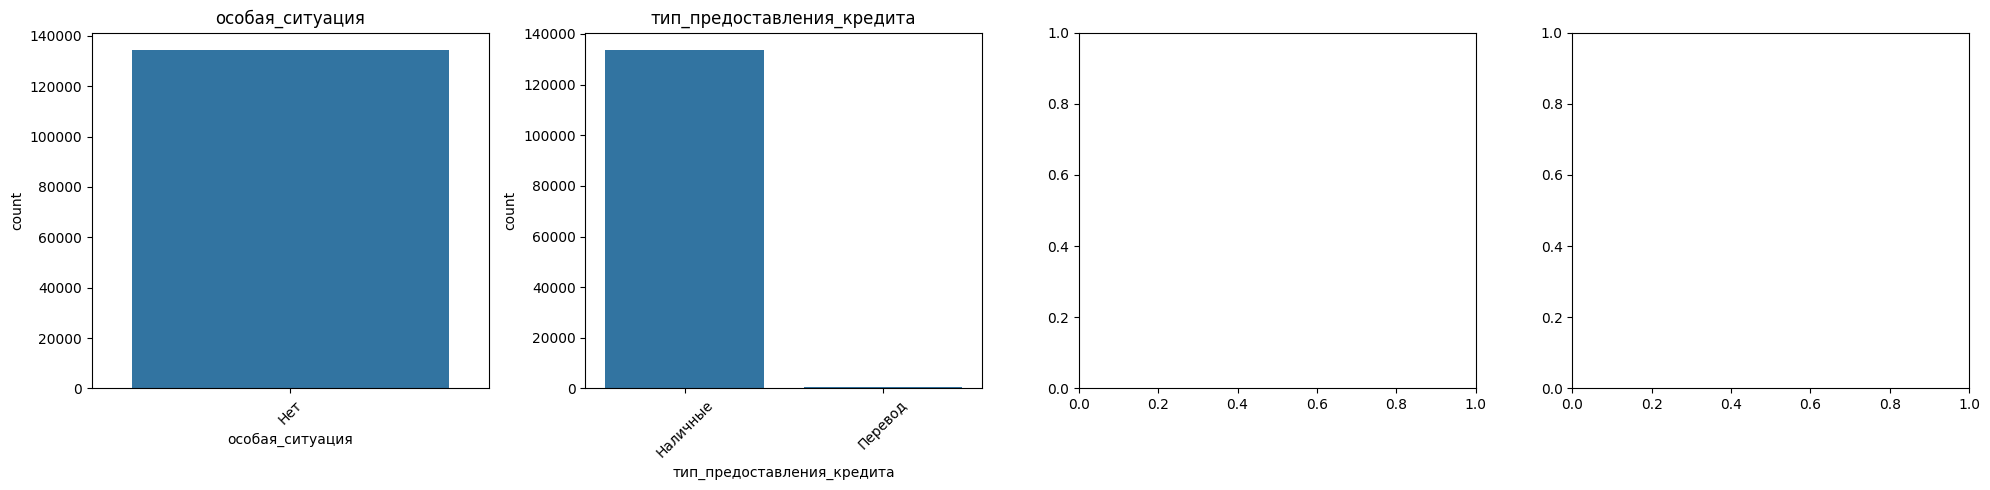

In [33]:
# посмотрим на распределения категориальных признаков в test

for i in range(0, len(cat_cols), 4):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    batch = cat_cols[i:i+4]

    for j, col in enumerate(batch):
        # топ-10 самых частых значений
        top_cats = test[col].value_counts().nlargest(10).index
        filtered_data = test[test[col].isin(top_cats)]

        sns.countplot(data=filtered_data, x=col, ax=axes[j])
        axes[j].set_title(col, fontsize=12)
        axes[j].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

    del fig, axes, batch, filtered_data  # удаляем переменные
    gc.collect()  # собираем мусор

Рассмотрим некоторые признаки подробнее.

Например, в числовых признаках есть группы, начинающиеся со слов 'совокупный...', а также 'кол-во месяцев с ...   просрочек/нарушений' и в них много пропущенных значений.

In [34]:
# сгруппируем признаки с приставкой 'совокупный..' по типу займа

grouped_loantype = train[['тип_займа',
                    'совокупный_доход_заемщиков',
                    'совокупный_пдн_заемщиков',
                    'совокупный_статус_подтверждения_доходов_заемщиков']]

group_1 = grouped_loantype[grouped_loantype['тип_займа'] == 'Индивидуальный']
group_2 = grouped_loantype[grouped_loantype['тип_займа'] == 'Совместный']

In [35]:
# тип займа - Индивидуальный

group_1.head()

,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков
0,Индивидуальный,NaN,NaN,NaN
2,Индивидуальный,NaN,NaN,NaN
3,Индивидуальный,NaN,NaN,NaN
4,Индивидуальный,NaN,NaN,NaN
5,Индивидуальный,NaN,NaN,NaN


In [36]:
group_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1187546 entries, 0 to 1210778
Data columns (total 4 columns):
 #   Column                                             Non-Null Count    Dtype  
---  ------                                             --------------    -----  
 0   тип_займа                                          1187546 non-null  object 
 1   совокупный_доход_заемщиков                         0 non-null        float64
 2   совокупный_пдн_заемщиков                           0 non-null        float64
 3   совокупный_статус_подтверждения_доходов_заемщиков  0 non-null        object 
dtypes: float64(2), object(2)
memory usage: 45.3+ MB


In [37]:
# тип займа - Совместный

group_2.head()

,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков
1,Совместный,3550000.00,13.85,Не подтвержден
349,Совместный,3850000.00,15.40,Не подтвержден
404,Совместный,5665700.00,25.44,Не подтвержден
419,Совместный,5850000.00,22.76,Не подтвержден
511,Совместный,4717416.00,17.07,Не подтвержден


In [38]:
group_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23233 entries, 1 to 1210763
Data columns (total 4 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   тип_займа                                          23233 non-null  object 
 1   совокупный_доход_заемщиков                         23233 non-null  float64
 2   совокупный_пдн_заемщиков                           23231 non-null  float64
 3   совокупный_статус_подтверждения_доходов_заемщиков  23050 non-null  object 
dtypes: float64(2), object(2)
memory usage: 907.5+ KB


В признаках 'совокупный_доход_заемщиков', 'совокупный_пдн_заемщиков', 'совокупный_статус_подтверждения_доходов_заемщиков' огромное количество пропусков (почти все значения) и связано это с признаком 'тип_займа'. В данном случае, для Индивидуального займа не требуется подтверждать что-то совместно, поэтому эти столбцы остались незаполненными. Такие пропуски целесообразно заполнить нулями. А в этих же столбцах, но при типе займа Совместный, уже можно использовать статистики при заполнении пропусков.

In [39]:
# сгруппируем признаки, связанные с нарушениями и просрочками, с итоговым статусом займа

grouped_loanstatus = train[['итоговый_статус_займа',
                    'кол-во_месяцев_с_последнего_нарушения',
                    'кол-во_месяцев_с_последней_просрочки',
                    'кол-во_месяцев_с_последнего_займа',
                    'кол-во_мес_с_последней_задолженности_по_возобновляемому_счету']]

group_1 = grouped_loanstatus[grouped_loanstatus['итоговый_статус_займа'] == 0]
group_2 = grouped_loanstatus[grouped_loanstatus['итоговый_статус_займа'] == 1]

In [40]:
# для выплаченных займов

group_1.head(10)

,итоговый_статус_займа,кол-во_месяцев_с_последнего_нарушения,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету
0,0,NaN,6.00,NaN,6.00
1,0,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN
3,0,NaN,49.00,NaN,NaN
4,0,3.00,3.00,NaN,NaN
5,0,NaN,NaN,106.00,NaN
6,0,75.00,75.00,NaN,NaN
7,0,NaN,NaN,NaN,NaN
9,0,NaN,42.00,NaN,42.00
10,0,NaN,NaN,NaN,NaN


In [41]:
group_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 969085 entries, 0 to 1210777
Data columns (total 5 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   итоговый_статус_займа                                          969085 non-null  int64  
 1   кол-во_месяцев_с_последнего_нарушения                          248686 non-null  float64
 2   кол-во_месяцев_с_последней_просрочки                           476016 non-null  float64
 3   кол-во_месяцев_с_последнего_займа                              158896 non-null  float64
 4   кол-во_мес_с_последней_задолженности_по_возобновляемому_счету  321340 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 44.4 MB


In [42]:
group_2.head(10)

,итоговый_статус_займа,кол-во_месяцев_с_последнего_нарушения,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету
8,1,NaN,NaN,75.00,NaN
19,1,NaN,18.00,NaN,18.00
23,1,55.00,33.00,66.00,33.00
24,1,NaN,NaN,NaN,NaN
26,1,NaN,NaN,NaN,NaN
32,1,NaN,NaN,NaN,NaN
44,1,NaN,NaN,NaN,NaN
47,1,NaN,NaN,NaN,NaN
49,1,NaN,NaN,NaN,NaN
50,1,69.00,33.00,NaN,NaN


In [43]:
group_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241694 entries, 8 to 1210778
Data columns (total 5 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   итоговый_статус_займа                                          241694 non-null  int64  
 1   кол-во_месяцев_с_последнего_нарушения                          69973 non-null   float64
 2   кол-во_месяцев_с_последней_просрочки                           124202 non-null  float64
 3   кол-во_месяцев_с_последнего_займа                              46766 non-null   float64
 4   кол-во_мес_с_последней_задолженности_по_возобновляемому_счету  83840 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 11.1 MB


Пропуски в признаках с различными нарушениями сроков не коррелируют строго с целевым признаком 'итоговый_статус_займа', но пропуски означают тоже скорее всего отсутствие данных (как бы 0, отсутствие просрочек). Можно заполнить пропуски в подобных столбцах нулями.

С другой стороны, некоторые значения, например, в 'кол-во_месяцев_с_последней_просрочки' пересекаются со значениями в 'кол-во_мес_с_последней_задолженности_по_возобновляемому_счету'. Если знать специфику этих признаков, возможно некотрые из этих признаков можно было бы заполнить данными из друг друга. К сожалению, такого понимания нет.

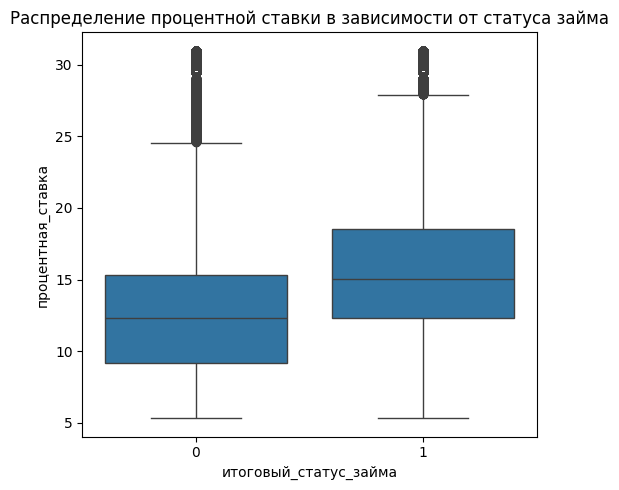

9623

In [44]:
# посмотрим на распределение процентной ставки в зависимости от статуса займа

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=train, x='итоговый_статус_займа', y='процентная_ставка')
plt.title('Распределение процентной ставки в зависимости от статуса займа')

plt.tight_layout()
plt.show()
plt.close(fig)

del fig # удаляем переменные
gc.collect() # собираем мусор

В целом видно, что медианное значение процентной ставки, а также её 0.25 и 0.75 квантили выше для невыплаченных кредитов, чем для выплаченных.

In [45]:
# основные статистики по процентной ставке в зав-ти от статуса займа

stats = train.groupby('итоговый_статус_займа')['процентная_ставка'].describe()
stats['median'] = train.groupby('итоговый_статус_займа')['процентная_ставка'].median()
stats['IQR'] = stats['75%'] - stats['25%']

display(stats)

,count,mean,std,min,25%,50%,75%,max,median,IQR
итоговый_статус_займа,,,,,,,,,,
0,969085.00,12.62,4.53,5.31,9.17,12.29,15.31,30.99,12.29,6.14
1,241694.00,15.71,4.91,5.31,12.29,15.05,18.55,30.99,15.05,6.26


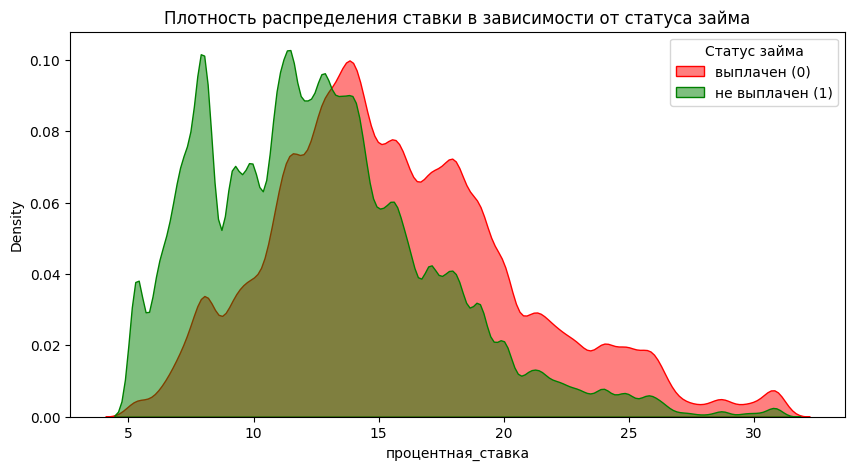

3593

In [46]:
# посмотрим на форму распределения процентной ставки в зависимости от класса целевого признака 'итоговый_статус_займа'

fig = plt.figure(figsize=(10, 5))
sns.kdeplot(
    data=train,
    x='процентная_ставка',
    hue='итоговый_статус_займа',
    fill=True,
    common_norm=False,
    alpha=0.5,
    palette={0: 'green', 1: 'red'}
)
plt.title('Плотность распределения ставки в зависимости от статуса займа')
plt.legend(title='Статус займа', labels=['выплачен (0)', 'не выплачен (1)'])
plt.show()
plt.close(fig)

del fig
gc.collect()

Среди невыплаченных кредитов наблюдаются два пика на уровне процентной ставки примерно 7.5%, а также 11% и 13%. Среди выплаченных пик ставки около 14%, второй пик поменьше примерно 18%.

In [47]:
# посмотрим как распределяется итоговый статус займа в зависимости от рейтинга заемщика

rating_analysis = train.groupby('рейтинг')['итоговый_статус_займа'].agg(['mean', 'count'])
rating_analysis.columns = ['Доля дефолтов', 'Количество займов']
display(rating_analysis)

,Доля дефолтов,Количество займов
рейтинг,,
А,0.06,211521
Б,0.13,353530
В,0.22,343586
Г,0.30,180714
Д,0.38,84394
Е,0.45,28842
Ж,0.50,8192


Тут закономерная картина: чем хуже рейтинг, тем больше доля дефолтов.

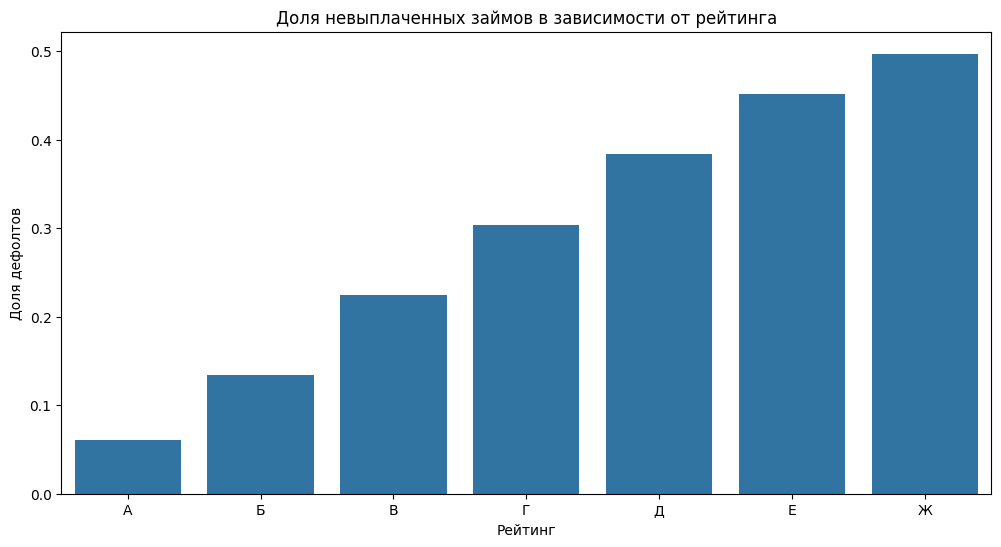

3471

In [48]:
# визуализация

fig = plt.figure(figsize=(12, 6))
sns.barplot(x=rating_analysis.index, y='Доля дефолтов', data=rating_analysis)
plt.title('Доля невыплаченных займов в зависимости от рейтинга')
plt.ylabel('Доля дефолтов')
plt.xlabel('Рейтинг')
plt.show()
plt.close(fig)

del fig
gc.collect()

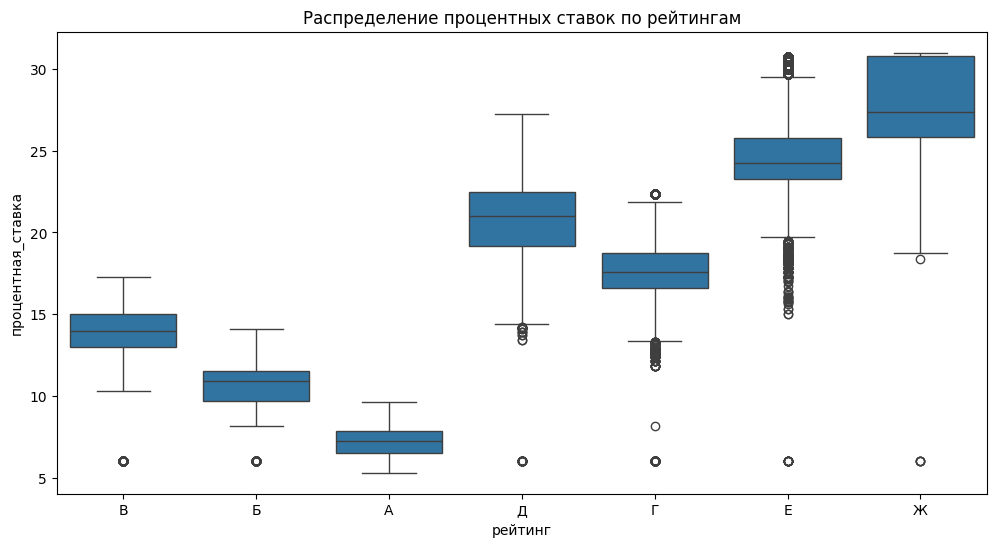

3719

In [49]:
# распределение процентной ставки по рейтингам

fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='рейтинг', y='процентная_ставка', data=train)
plt.title('Распределение процентных ставок по рейтингам')
plt.show()
plt.close(fig)

del fig
gc.collect()

Межквартильный размах процентой ставки тем выше, чем хуже рейтинг заемщика.

In [50]:
# посмотрим как распределяется итоговый статус займа в зависимости от допрейтинга заемщика

rating_analysis_2 = train.groupby('допрейтинг')['итоговый_статус_займа'].agg(['mean', 'count'])
rating_analysis_2.columns = ['Доля дефолтов', 'Количество займов']
display(rating_analysis_2)

,Доля дефолтов,Количество займов
допрейтинг,,
А1,0.03,39157
А2,0.05,33402
А3,0.06,34181
А4,0.07,47017
А5,0.08,57764
Б1,0.10,64082
Б2,0.11,66645
Б3,0.13,73444
Б4,0.15,74965


Аналогичная ситуация с допрейтингом: с ухудшением допрейтинга доля невыплаченных займов растет. Есть даже некая закономерность в росте - на 0.01-0.02% с каждым последующим шагом допрейтинга. За исключением небольших попарных скачков между разными уровнями допрейтинга Е и Ж.

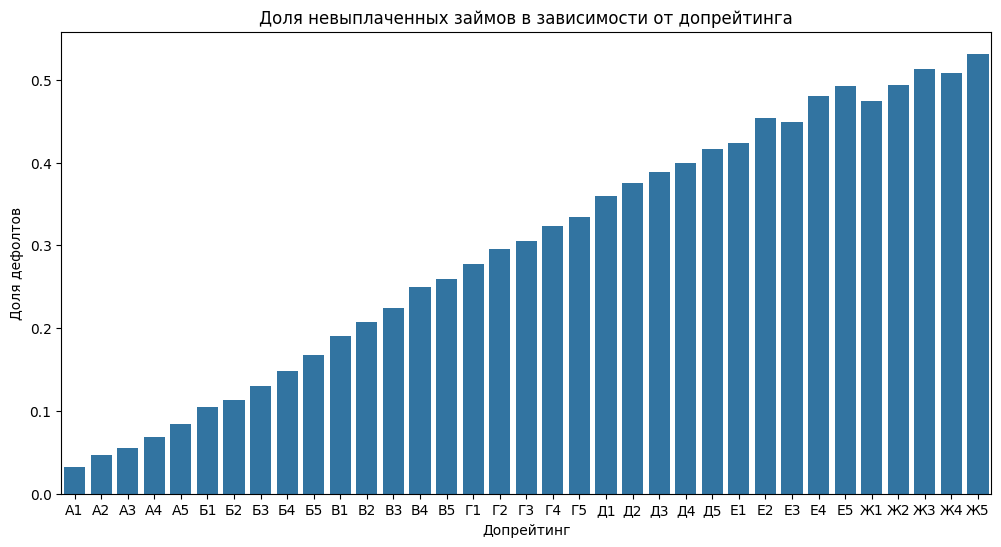

6047

In [51]:
# визуализация

fig = plt.figure(figsize=(12, 6))
sns.barplot(x=rating_analysis_2.index, y='Доля дефолтов', data=rating_analysis_2)
plt.title('Доля невыплаченных займов в зависимости от допрейтинга')
plt.ylabel('Доля дефолтов')
plt.xlabel('Допрейтинг')
plt.show()
plt.close(fig)

del fig
gc.collect()

In [52]:
# посмотрим как распределяется итоговый статус займа в зависимости от цели кредита

purpose_analysis = train.groupby('цель_займа')['итоговый_статус_займа'].agg(['mean', 'count'])
purpose_analysis.columns = ['Доля дефолтов', 'Количество займов']
purpose_analysis = purpose_analysis.sort_values('Доля дефолтов', ascending=False)
display(purpose_analysis)

,Доля дефолтов,Количество займов
цель_займа,,
мелкий_бизнес,0.30,13908
возобновляемая_энергия,0.24,832
переезд,0.23,8547
дом,0.22,6522
лечение,0.22,13983
консолидация_долга,0.21,702475
другое,0.21,70166
отпуск,0.19,8127
крупная_покупка,0.18,26558


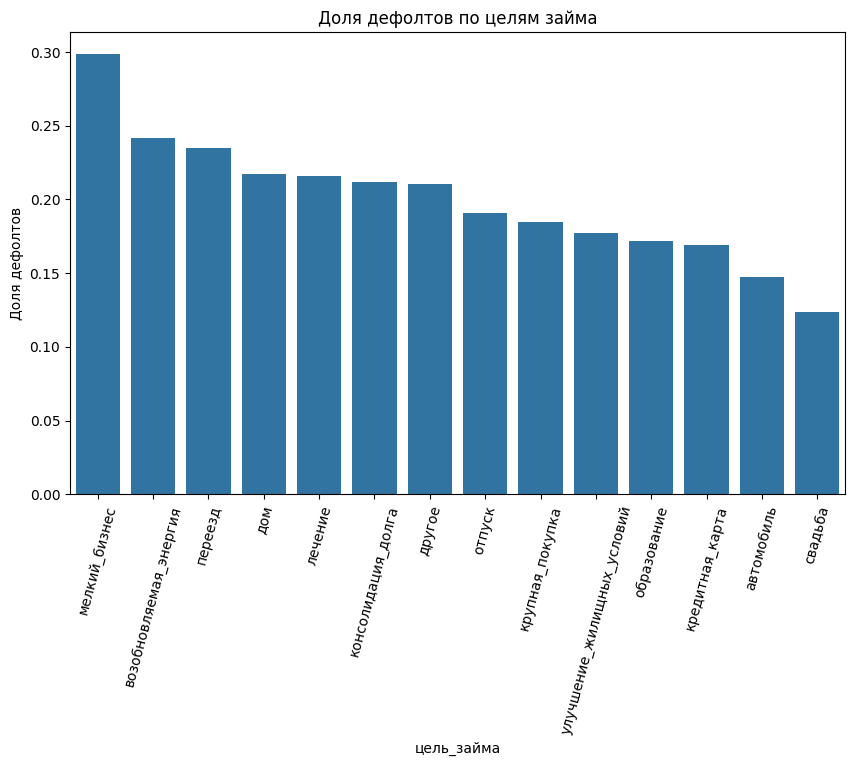

9845

In [53]:
# визуализация

fig = plt.figure(figsize=(10, 6))
sns.barplot(
    x=purpose_analysis.index,
    y='Доля дефолтов',
    data=purpose_analysis)
plt.xticks(rotation=75)
plt.title('Доля дефолтов по целям займа')
plt.show()
plt.close(fig)

del fig
gc.collect()

В топе-5 самые рисковые цели кредита: мелкий бизнес, возобновляемая энергия, переезд, дом, лечение.

In [54]:
# посмотрим на долю невыплаченных кредитов среди тех, кто платил пени за дефолт и тех, кто нет

# cоздадим копию данных с заполнением NaN, чтобы учесть пропуски
df_analysis = train[['пени_за_дефолт', 'итоговый_статус_займа']].copy()
df_analysis['пени_за_дефолт'] = df_analysis['пени_за_дефолт'].fillna('NaN')

# посчитаем распределение
analysis = (
    df_analysis.groupby('пени_за_дефолт')['итоговый_статус_займа']
    .value_counts(dropna=False)
    .unstack()
    .fillna(0)
)

analysis.columns = ['Выплачен (0)', 'Не выплачен (1)']

# добавим расчётные столбцы
analysis['Всего'] = analysis.sum(axis=1)
analysis['Доля не выплаченных'] = analysis['Не выплачен (1)'] / analysis['Всего']
total_defaults = analysis['Не выплачен (1)'].sum()
analysis['Доля от всех невыплаченных'] = analysis['Не выплачен (1)'] / total_defaults

# добавим итоговую строку
analysis.loc['Всего'] = analysis.sum()

# переименуем индексы
analysis.index = analysis.index.map({
    True: 'True (есть пени)',
    False: 'False (нет пени)',
    'NaN': 'Пропуски',
    'Всего': 'Всего'})

In [55]:
# отформатируем вывод с помощью функции

def format_numbers(x):
    if isinstance(x, (int, float)):
        return f"{x:,.0f}" if x == x else "-"
    return x

formated = analysis.style.format({
    'Выплачен (0)': format_numbers,
    'Не выплачен (1)': format_numbers,
    'Всего': format_numbers,
    'Доля не выплаченных': '{:.2%}',
    'Доля от всех невыплаченных': '{:.2%}'
})

display(formated)

,Выплачен (0),Не выплачен (1),Всего,Доля не выплаченных,Доля от всех невыплаченных
пени_за_дефолт,,,,,
False (нет пени),"677,863","58,093","735,956",7.89%,24.04%
True (есть пени),0,"111,382","111,382",100.00%,46.08%
Пропуски,"291,222","72,219","363,441",19.87%,29.88%
Всего,"969,085","241,694","1,210,779",127.76%,100.00%


Нетрудно заметить, если пени за дефолт были, то займы были не выплачены. Но если пеней не было, то все равно есть небольшая доля (около 8%) невыплаченных займов.

В признаке пени_за_дефолт около 30% пропусков, в которых так же скрывается около 20% (от этих пропусков) невыплаченных займов.

Если рассматривать только невыплаченные займы: то среди них 24% не были оштрафованы, около 46% - были, и около 30% осталось тайной.

Пока непонятно как восстанавливать этот признак в тестовой выборке.

In [56]:
# посмотрим на долю невыплаченных кредитов среди тех, у кого стоит 'сумма_по_просрочкам' и тех, у кого нет

# создадим бинарный признак 'были ли выплаты по просрочкам' ( если в столбце сумма > 0)
train_df = train[['сумма_выплат_по_просрочкам', 'итоговый_статус_займа']].copy()
train_df['были_выплаты'] = train_df['сумма_выплат_по_просрочкам'] > 0

# строим таблицу сопряженности
cross_table = pd.crosstab(
    index=train_df['итоговый_статус_займа'],
    columns=train_df['были_выплаты'],
    margins=True,
    margins_name="Всего"
)

# переименовываем для наглядности
cross_table.columns = ['Нет выплат (0.00)', 'Есть выплаты (>0)', 'Всего']
cross_table.index = ['Выплачен (0)', 'Не выплачен (1)', 'Всего']

# добавим доли
cross_table['Доля с выплатами'] = cross_table['Есть выплаты (>0)'] / cross_table['Всего']

display(cross_table.style.format({
    'Нет выплат (0.00)': '{:,}',
    'Есть выплаты (>0)': '{:,}',
    'Всего': '{:,}',
    'Доля с выплатами': '{:.2%}'}))

,Нет выплат (0.00),Есть выплаты (>0),Всего,Доля с выплатами
Выплачен (0),"947,600","21,485","969,085",2.22%
Не выплачен (1),"209,590","32,104","241,694",13.28%
Всего,"1,157,190","53,589","1,210,779",4.43%


В примерно 4.5% от всех наблюдений были выплаты по просрочкам, из них 40% - кредиты выплачены (итоговый статус займа 0) и 60% - не выплачены (итоговый статус займа 1).

В примерно 95.5% от всех наблюдений выплат по просрочкам не было. При этом в 18% кредит не был выплачен, а в 82% кредит был выплачен.

## Корреляция числовых признаков для train

Посмотрим на корреляцию признаков с целевой переменной.

In [57]:
# расчет корреляций для числовых признаков

numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train[numeric_cols].corr()

In [58]:
# таблица корреляций с target

corr_with_target = corr_matrix['итоговый_статус_займа'].sort_values(ascending=False)
corr_table = pd.DataFrame(corr_with_target).reset_index()
corr_table.columns = ['Признак', 'Корреляция с target']
print('Топ-30 коррелирующих признаков с target:')
display(corr_table.head(30))

Топ-30 коррелирующих признаков с target:


,Признак,Корреляция с target
0,итоговый_статус_займа,1.00
1,процентная_ставка,0.26
2,совокупный_пдн_заемщиков,0.14
3,сумма_выплат_по_просрочкам,0.14
4,кол-во_открытых_счетов_за_2_года,0.10
5,соотношение_баланса_к_лимиту_общее,0.09
6,кол-во_счетов_за_посл_год,0.09
7,пдн,0.08
8,кол-во_возоб_счетов_за_2_года,0.08
9,кол-во_активных_возобновляемых_счетов,0.07


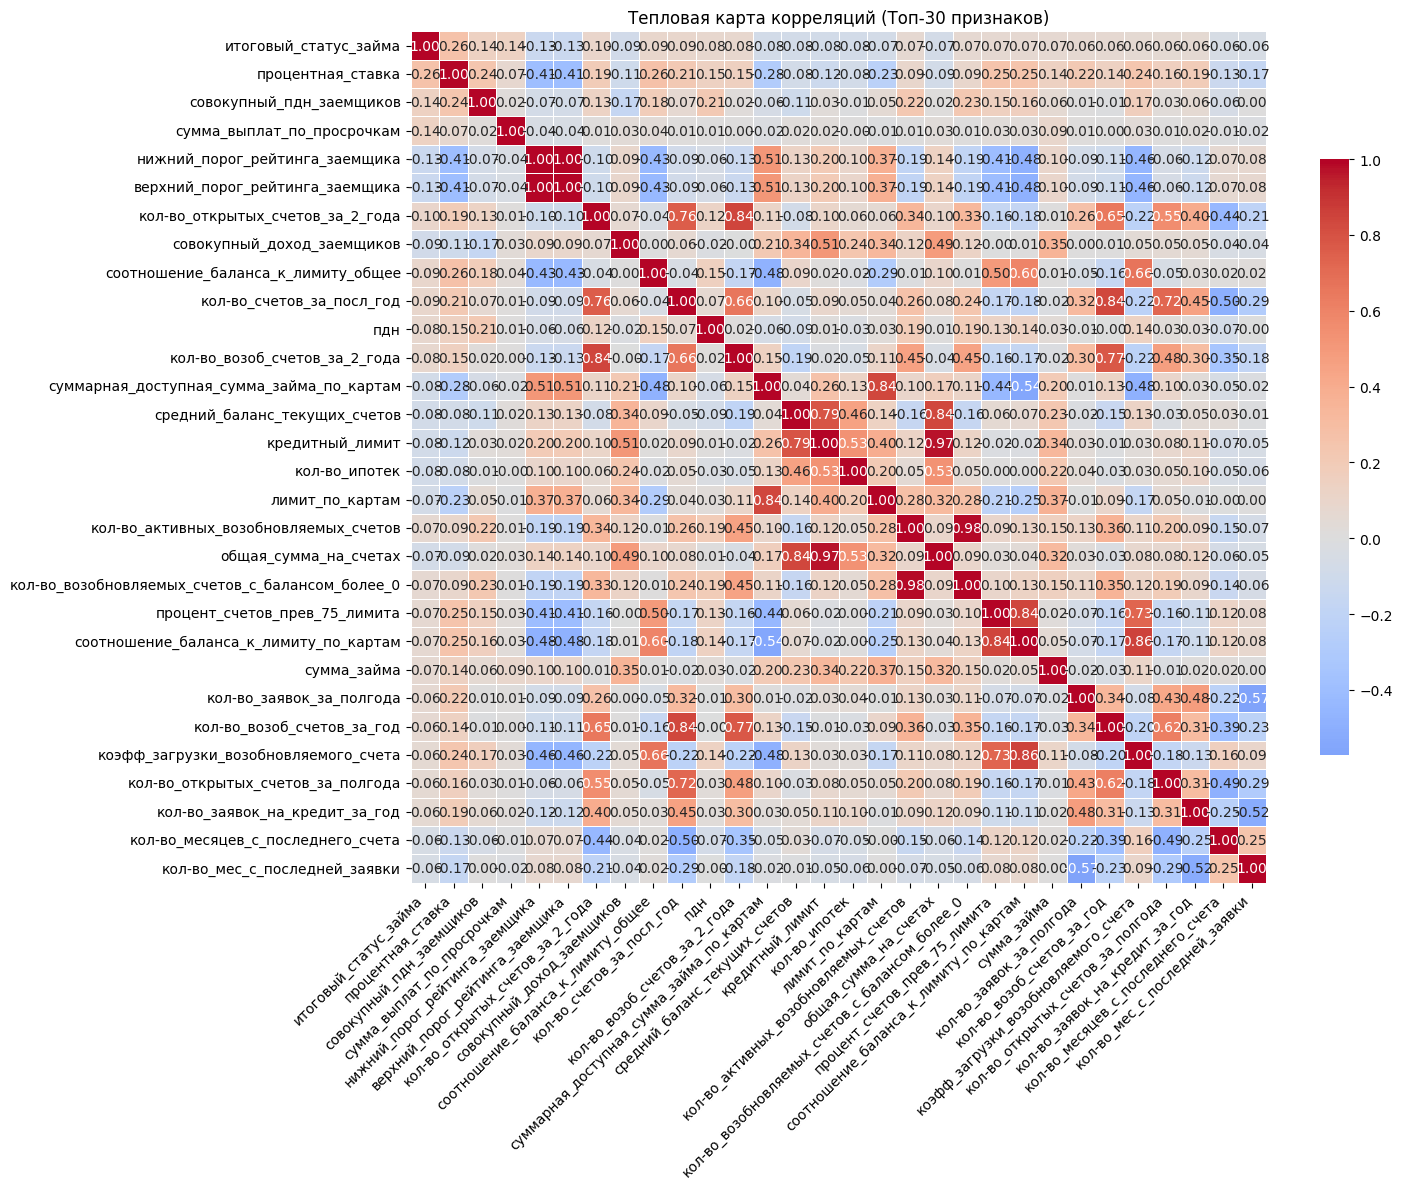

64758

In [59]:
# построим тепловую карту для топ-30 признаков

top_features = corr_with_target.abs().sort_values(ascending=False).head(30).index.tolist()
fig = plt.figure(figsize=(15, 12))
sns.heatmap(train[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Тепловая карта корреляций (Топ-30 признаков)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close(fig)

del fig
gc.collect()

## Корреляция категориальных признаков для train

Для оценки силы связи меду категориальными признаками используем коэффициент Крамера V

In [60]:
# функция для расчета Cramer's V

def cramers_v(x, y):
    # обработка пропусков
    confusion_matrix = pd.crosstab(x.fillna('NaN'), y.fillna('NaN'))

    if confusion_matrix.size == 0 or min(confusion_matrix.shape) == 1:
        return 0.0

    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()

    # не делить на ноль
    denominator = n * (min(confusion_matrix.shape) - 1)
    if denominator <= 0:
        return 0.0

    return np.sqrt(chi2 / denominator)

In [61]:
# расчет корреляций для категориальных признаков

cat_cols = train.select_dtypes(include=['object']).columns.tolist()

corr_table = train[cat_cols].apply(lambda x: cramers_v(x, train['итоговый_статус_займа']))\
                           .abs()\
                           .to_frame('Корреляция с target')\
                           .sort_values('Корреляция с target', ascending=False)

print("Корреляция категориальных признаков по Cramer's V:")
display(corr_table)

Корреляция категориальных признаков по Cramer's V:


,Корреляция с target
пени_за_дефолт,0.65
профессия_заемщика,0.48
допрейтинг,0.27
рейтинг,0.26
срок_займа,0.18
подтвержден_ли_доход,0.09
владение_жильем,0.07
дата_первого_займа,0.06
цель_займа,0.06
регион,0.05


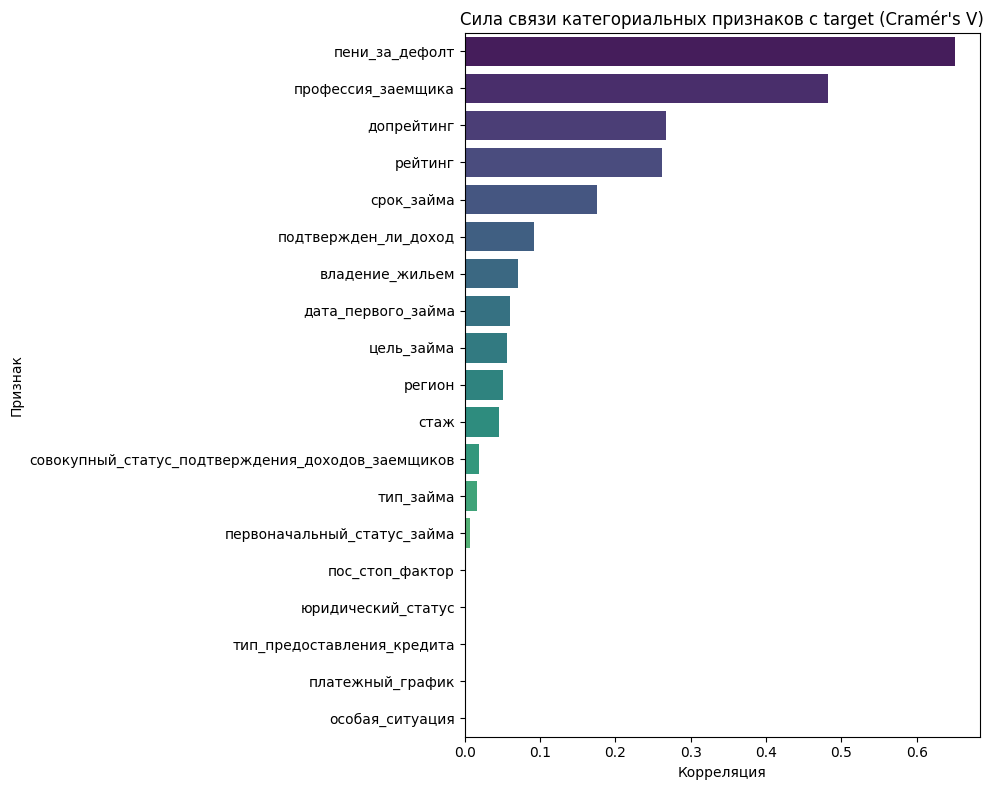

194

In [62]:
# построим барплот для визуализации

fig = plt.figure(figsize=(10, 8))
sns.barplot(x='Корреляция с target', y=corr_table.index, hue=corr_table.index, data=corr_table.reset_index(), palette='viridis')
plt.title('Сила связи категориальных признаков с target (Cramér\'s V)')
plt.xlabel('Корреляция')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()
plt.close(fig)

del fig
gc.collect()

В связи с большим количеством данных обнаружилась проблема с переполнением ОЗУ в google colab и перезапуском среды в самое неподходящее время, поэтому было принято решение очищать память после каждого этапа работ путем удаления созданных переменных и сбора мусора.

In [67]:
# функция для удаления временных объектов и специально созданных для анализа переменных

def clear_temporary_objects():
    initial_count = len(gc.get_objects())

    # удаляем именованные переменные
    large_vars = ['filtered_data', 'grouped_loantype', 'df_analysis', 'grouped_loanstatus',
                 'group_1', 'train_df', 'group_2', 'stats', 'rating_analysis', 'rating_analysis_2',
                 'purpose_analysis', 'corr_matrix', 'corr_with_target', 'corr_table', 'top_features',
                 'cross_table', 'meta_info', 'missing_analysis', 'top_missing', 'meta_info_test',
                 'top_missing_test', 'missing_analysis_test']

    for var_name in large_vars:
        if var_name in globals():
            del globals()[var_name]
            print(f'Удалена переменная: {var_name}')

    # удаляем большие безымянные столбцы
    series_cleared = 0
    for obj in gc.get_objects():
        try:
            if isinstance(obj, pd.Series) and sys.getsizeof(obj) > 50000000:  # > 50MB
                del obj
                series_cleared += 1
        except:
            continue

    # принудительная сборка мусора
    gc.collect()

    final_count = len(gc.get_objects())
    print(f'Освобождено объектов: {initial_count - final_count}')
    print(f'Удалено больших столбцов: {series_cleared}')

In [68]:
# применение функции

clear_temporary_objects()

Удалена переменная: grouped_loantype
Удалена переменная: df_analysis
Удалена переменная: grouped_loanstatus
Удалена переменная: group_1
Удалена переменная: train_df
Удалена переменная: group_2
Удалена переменная: stats
Удалена переменная: rating_analysis
Удалена переменная: rating_analysis_2
Удалена переменная: purpose_analysis
Удалена переменная: corr_matrix
Удалена переменная: corr_with_target
Удалена переменная: corr_table
Удалена переменная: top_features
Удалена переменная: cross_table
Удалена переменная: meta_info
Удалена переменная: missing_analysis
Удалена переменная: top_missing
Удалена переменная: meta_info_test
Удалена переменная: top_missing_test
Удалена переменная: missing_analysis_test
Освобождено объектов: 9178
Удалено больших столбцов: 17


## Основные выводы по исследовательскому анализу данных

Предоставлены 2 датасета:

- **train**        1 210 779 строк
- **test**           134 531 строка

- Всего 108 признаков + 1 целевая переменная _'итоговый_статус_займа'_. Описания признаков нет.

- Целевая переменная имеет два значения (бинарная классификация): 0 - выплачен, 1 - не выплачен.

- Есть значительный дисбаланс классов целевой переменной в соотношении 80% ('0') к 20% ('1').

- Метрика оценки качества - ROC-AUC

- В датасетах отсутствуют дубликаты и бесконечные значения.

- Есть несколько отрицательных значений.

- В train следующее распределение по типам данных признаков:
   * 6 признаков int64 (включая целевую переменную)
   * 84 признака float64
   * 19 признаков object
  
- За счет того, что в test отсутствуют значения признака _'пени_за_дефолт'_ и столбец полностью заполнен NaN, распределение по типам данных следующее:
   * 5 признаков int64 (целевой переменной нет)
   * 85 признаков float64  (+1)
   * 18 признаков object   (-1)

- В обеих выборках полностью отсутствуют значения признака _'дата_следующей_выплаты'_. Этот признак будет удален.

- В обеих выборках есть признаки - 'платежный_график', 'особая_ситуация', 'код_политики', 'непогашенная_сумма_из_тела_займов', 'коэфф_невыплаченного_сумм_остатка' - заполненные одним-единственным значением (каждый - своим). Возможно такие признаки не информативны для классификации целевой переменной. Тогда их тоже можно будет удалить.

- Признак 'индекс_проживания' представлен в датасетах трехзначным числом вместо шестизначного. Встречаются 2-значные и 1-значные индексы. Есть 1 пропуск в train. Также в датасетах есть признак 'регион'. Первые три цифры почтового индекса тоже указывают на регион. Если для изучения и анализа данных человеку удобнее использовать название региона, то для обучения модели можно было бы оставить только индексы (они типа float64) и, удалив признак 'регион', избавиться от кодирования значительного количества его категорий (50). Но странные 1- и 2-значные индексы призывают скорее удалить столбец с ними.

- В обоих датасетах очень много пропусков.

   * Для train:
     - В 26 признаках (из 108) более 10% пропусков в данных:
      * 1 признак 100% пропусков
      * 4 признака более 98% пропусков
      * 21 признак от 10% до 85% пропусков

   * Для test:
     - В 26 признаках (из 108) более 10% пропусков в данных:
      * 2 признака 100% пропусков
      * 4 признака более 98% пропусков
      * 20 признаков от 10% до 85% пропусков


- Так как пропусков слишком много и их удаление приведет к огромной потере данных, то пропуски будут заполнены на основе имеющихся данных и предположений автора.

- Медианное значение процентной ставки, а также её 0.25 и 0.75 квантили выше для невыплаченных кредитов, чем для выплаченных.

- Доля невыплаченных кредитов возрастает с ростом (ухудшением) рейтинга (от A к Ж)

- Хорошо просматривается зависимость процентной ставки от рейтинга заёмщика - чем хуже рейтинг (ближе к Ж), тем выше ставка.

- Топ-5 рискованных целей кредита (т.е.склонных к невыплате) (по убыванию):
   * мелкий бизнес
   * возобновляемая энергия
   * переезд
   * дом
   * лечение

- Анализ корреляции численных признаков не выявил их сильного или ярко выраженного влияния на целевую переменную (_'итоговый_статус_займа'_). Топ-5 численных признаков по убыванию корреляции:
   * _'процентная_ставка'_            (0.26)
   * _'совокупный_пдн_заемщиков'_     (0.14)
   * _'сумма_выплат_по_просрочкам'_	  (0.14)
   * _'кол-во_открытых_счетов_за_2_года'_	(0.10)
   * _'соотношение_баланса_к_лимиту_общее'_

       и _'кол-во_счетов_за_посл_год'_	   (0.09)


 - Анализ корреляции категориальных признаков, наоборот, выявил их более сильные связи с целевой переменной. Топ-5 категориальных признаков по убыванию силы связи:
   * _'пени_за_дефолт'_    (0.65)
   * _'профессия_заемщика'_  (0.48)
   * _'допрейтинг'_ (0.27)
   * _'рейтинг'_  (0.26)
   * _'срок_займа'_  (0.18)

- _'пени_за_дефолт'_ - признак, который наиболее сильно коррелирует с целевой переменной и который полностью отсутствует в test


- В test нет ни одного значения признака _'пени_за_дефолт'_. В train из 1 210 779 наблюдений известны значения этого признака у 847 338 (примерно 70% от всей выборки) со следующим дисбалансом классов: False - 735 956, True - 111 382.




# Простая (быстрая) обработка данных и построение бэйзлайн-модели

Построим бэйзлайн-модель(-и) на не тщательно обработанных данных для понимания, какую метрику можно получить.

## Простая предобработка

In [75]:
# удаляем один признак из train и test (100% пропусков в обеих выборках)

train_base = train.drop(columns=['дата_следующей_выплаты'])
test_base = test.drop(columns=['дата_следующей_выплаты'])

In [76]:
# функция для быстрой обработки данных
# пропуски заполняются модами в категориальных признаках
# и медианами в числовых признаках
# категориальные признаки кодируются LabelEncoder

def preprocess_data(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [77]:
train_base = preprocess_data(train_base)
test_base = preprocess_data(test_base)

/tmp/ipython-input-1726925549.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


Разделим train выборку на обучающий набор и валидационный в соотношении 80% к 20%.

In [78]:
# разделим данные на train/valid (80%/20%)

X_b = train_base.drop(columns=['итоговый_статус_займа'])
y_b = train_base['итоговый_статус_займа']

X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(
    X_b, y_b, test_size=0.2, random_state=RANDOM_STATE, stratify=y_b
)

## Бэйзлайн-модель

### LightGBM

In [79]:
# параметры LightGBM

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'random_state': RANDOM_STATE,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'scale_pos_weight': len(y_train_b[y_train_b==0]) / len(y_train_b[y_train_b==1]),  # учет дисбаланса
    'verbosity': -1
}

In [80]:
# данные в формате LightGBM

train_data = lgb.Dataset(X_train_b, label=y_train_b)
valid_data = lgb.Dataset(X_valid_b, label=y_valid_b, reference=train_data)

In [81]:
# обучение

model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.864173	valid_1's auc: 0.861524
[100]	training's auc: 0.869513	valid_1's auc: 0.865922
[150]	training's auc: 0.8726	valid_1's auc: 0.868029
[200]	training's auc: 0.874795	valid_1's auc: 0.869131
[250]	training's auc: 0.876696	valid_1's auc: 0.869855
[300]	training's auc: 0.878293	valid_1's auc: 0.870257
[350]	training's auc: 0.879694	valid_1's auc: 0.870472
[400]	training's auc: 0.881034	valid_1's auc: 0.870633
[450]	training's auc: 0.882332	valid_1's auc: 0.870752
[500]	training's auc: 0.883552	valid_1's auc: 0.870873
[550]	training's auc: 0.884722	valid_1's auc: 0.87094
[600]	training's auc: 0.885933	valid_1's auc: 0.871049
[650]	training's auc: 0.887078	valid_1's auc: 0.871104
[700]	training's auc: 0.88817	valid_1's auc: 0.871138
[750]	training's auc: 0.889263	valid_1's auc: 0.871171
[800]	training's auc: 0.890339	valid_1's auc: 0.871168
Early stopping, best iteration is:
[782]	training's auc: 0.88995

In [82]:
# метрика на валидации

y_valid_pred_lgb = model_lgb.predict(X_valid_b)
valid_roc_auc_lgb= roc_auc_score(y_valid_b, y_valid_pred_lgb)
print(f'ROC-AUC на валидации: {valid_roc_auc_lgb:.4f}')

ROC-AUC на валидации: 0.8712


Метрика очень хорошая.

In [83]:
# предсказания на test

test_pred_lgb = model_lgb.predict(test_base)

In [84]:
# выгрузка submission

submission_lgb = pd.DataFrame({'ID': test['id'], 'Proba': test_pred_lgb})
submission_lgb.to_csv('submission.csv', index=False)

### Важность признаков для LightGBM

In [85]:
# основные типы важности

importance_types = ['split', 'gain']
importance = {
    'gain': model_lgb.feature_importance(importance_type='gain'),
    'split': model_lgb.feature_importance(importance_type='split')
}

In [86]:
# получаем названия признаков
feature_names = model_lgb.feature_name()

# создаем табличку
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance_gain': importance['gain'],
    'Importance_split': importance['split']
}).sort_values('Importance_gain', ascending=False)

In [87]:
# выводим топ-20

print('Топ-20 важных признаков (по gain):')
display(feature_importance.head(20))

Топ-20 важных признаков (по gain):


,Feature,Importance_gain,Importance_split
39,пени_за_дефолт,5724315.94,207
6,допрейтинг,629763.00,296
38,сумма_выплат_по_просрочкам,490849.36,422
5,рейтинг,412731.28,84
0,id,233766.00,1182
2,срок_займа,137658.50,251
10,годовой_доход,98488.64,794
19,пдн,82853.84,640
7,профессия_заемщика,81697.29,783
3,процентная_ставка,76179.70,641


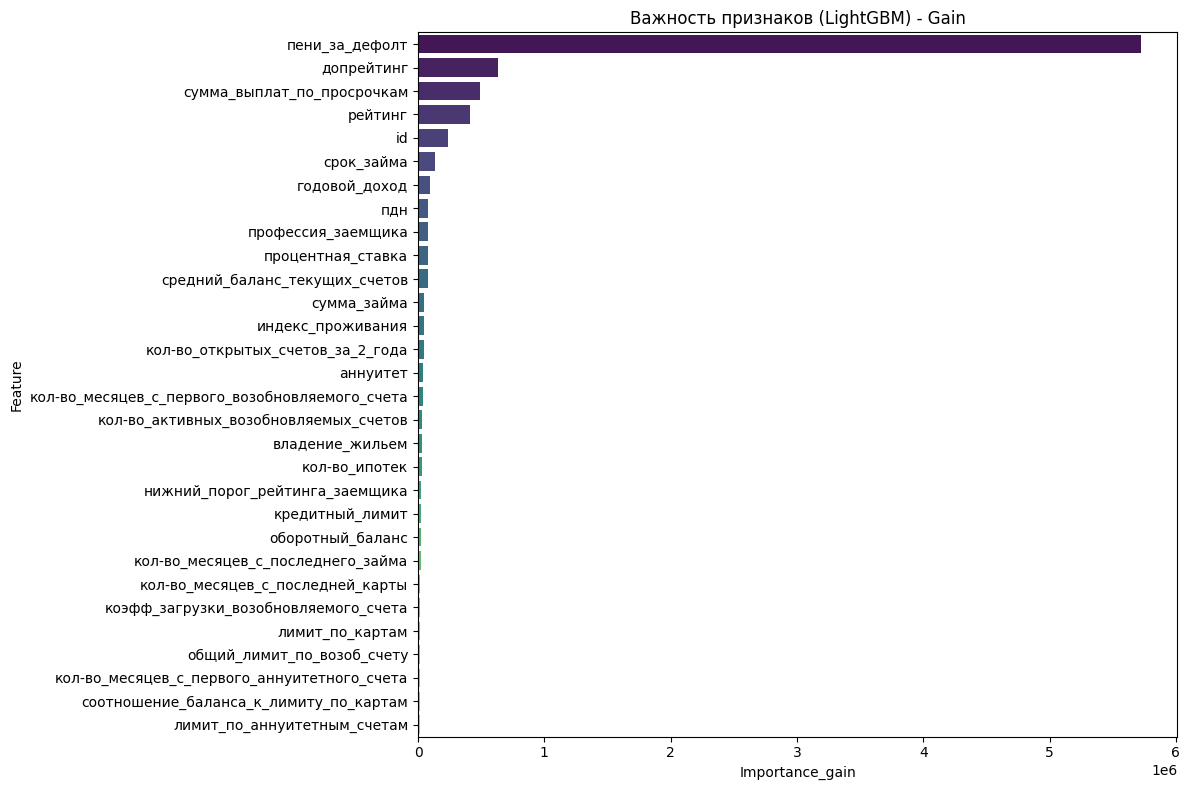

3227

In [88]:
# визуализация

fig = plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance_gain',
    y='Feature',
    hue='Feature',
    data=feature_importance.head(30),
    palette='viridis'
)
plt.title('Важность признаков (LightGBM) - Gain')
plt.tight_layout()
plt.show()
plt.close(fig)
del fig
gc.collect()

In [90]:
# для очистки памяти удалим специально созданные переменные и соберем мусор

del train_base, test_base, X_b, y_b, X_train_b, X_valid_b, y_train_b, y_valid_b, train_data, valid_data, y_valid_pred_lgb, valid_roc_auc_lgb, test_pred_lgb, submission_lgb, feature_importance
gc.collect()

9011

### Вывод по LightGBM

Модель обучилась на небрежно обработанных данных.

ROC-AUC на:

- обучающей выборке **0.889958**
- валидационной выборке **0.8712**
- тестовой выборке **0.7613** (инфо с платформы соревнования codabench)

Подбора гиперпараметров не было. Была применена ранняя остановка во избежание переобучения (и она сработала). На тестовой выборке метрика обвалилась. Модель оказалась переобученной. Целый столбец с признаком ('пени_за_дефолт') в тестовой выборке остался не заполненным. Из плюсов - время обучения достаточно короткое (~ 10 мин).

Получена информация о важных признаках для модели LightGBM. Из топ-10 важных признаков **7** из них перекликаются с признаками, выявленными при анализе корреляций с целевой переменной. Это:

- пени_за_дефолт
- допрейтинг
- сумма_выплат_по_просрочкам
- рейтинг
- срок_займа
- профессия_заемщика
- процентная_ставка


### CatBoost

Обучим ещё одну модель градиентного бустинга. Часто бывает, что она показывает лучшие результаты при прочих равных. При этом она не требует кодирования категориальных признаков (и очень хорошо с ними справляется) и не требует нормализации числовых признаков.

Заново подготовим данные.

In [94]:
# удаляем один признак из train и test (100% пропусков в обеих выборках)

train_base2 = train.drop(columns=['дата_следующей_выплаты'])
test_base2 = test.drop(columns=['дата_следующей_выплаты'])

In [95]:
# функция для быстрой обработки данных
# пропуски заполняются модами в категориальных признаках
# и медианами в числовых признаках
# категориальные признаки не кодируем для CatBoost

def preprocess_data_cat(df):

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    return df

In [96]:
train_base2 = preprocess_data_cat(train_base2)
test_base2 = preprocess_data_cat(test_base2)

/tmp/ipython-input-1130967137.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [97]:
# разделим данные на train/valid (80%/20%)

X_b = train_base2.drop(columns=['итоговый_статус_займа'])
y_b = train_base2['итоговый_статус_займа']

X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(
    X_b, y_b, test_size=0.2, random_state=RANDOM_STATE, stratify=y_b
)

In [98]:
# определяем категориальные признаки

cat_features = X_train_b.select_dtypes(include=['object']).columns.tolist()

In [99]:
# создаем Pool для CatBoost

train_pool = Pool(X_train_b, y_train_b, cat_features=cat_features)
valid_pool = Pool(X_valid_b, y_valid_b, cat_features=cat_features)

In [100]:
# параметры CatBoost

params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': RANDOM_STATE,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 100,
    'auto_class_weights': 'Balanced'
    #'task_type':'GPU'
}

In [101]:
# обучение

model_cat = CatBoostClassifier(**params)
model_cat.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose_eval=100
)

0:	test: 0.8440343	best: 0.8440343 (0)	total: 8.38s	remaining: 2h 19m 32s
100:	test: 0.8630987	best: 0.8630987 (100)	total: 7m 50s	remaining: 1h 9m 47s
200:	test: 0.8671682	best: 0.8671682 (200)	total: 15m 50s	remaining: 1h 2m 57s
300:	test: 0.8692342	best: 0.8692342 (300)	total: 23m 30s	remaining: 54m 35s
400:	test: 0.8710682	best: 0.8710682 (400)	total: 31m 2s	remaining: 46m 22s
500:	test: 0.8721603	best: 0.8721603 (500)	total: 38m 39s	remaining: 38m 30s
600:	test: 0.8728868	best: 0.8728878 (599)	total: 46m 17s	remaining: 30m 43s
700:	test: 0.8733878	best: 0.8733878 (700)	total: 53m 52s	remaining: 22m 58s
800:	test: 0.8737210	best: 0.8737210 (800)	total: 1h 1m 17s	remaining: 15m 13s
900:	test: 0.8739981	best: 0.8739981 (900)	total: 1h 8m 58s	remaining: 7m 34s
999:	test: 0.8742422	best: 0.8742422 (999)	total: 1h 16m 19s	remaining: 0us

bestTest = 0.8742421707
bestIteration = 999



In [102]:
# метрика на валидации

y_valid_pred_cat = model_cat.predict_proba(X_valid_b)[:, 1]
valid_roc_auc_cat = roc_auc_score(y_valid_b, y_valid_pred_cat)
print(f'ROC-AUC на валидации: {valid_roc_auc_cat:.4f}')

ROC-AUC на валидации: 0.8742


Метрика немногим (на тысячные доли) лучше, чем у LightGBM.

In [103]:
# предсказания на test

test_pred_cat = model_cat.predict_proba(test_base2)[:, 1]

In [104]:
# выгрузка submission

submission_cat = pd.DataFrame({'ID': test_base2['id'],'Proba': test_pred_cat})
submission_cat.to_csv('submission.csv', index=False)

### Важность признаков для CatBoost

In [105]:
# получаем важность признаков

feature_importance_cat = model_cat.get_feature_importance()
feature_names_cat = X_train_b.columns

In [106]:
# создаем табличку

feature_importance_cat = pd.DataFrame({
    'Feature': feature_names_cat,
    'Importance': feature_importance_cat
}).sort_values('Importance', ascending=False)

In [108]:
# выводим топ-20

print("Топ-20 важных признаков:")
display(feature_importance_cat.head(20))

Топ-20 важных признаков:


,Feature,Importance
39,пени_за_дефолт,85.40
5,рейтинг,1.57
6,допрейтинг,1.48
0,id,1.45
38,сумма_выплат_по_просрочкам,1.32
2,срок_займа,0.83
7,профессия_заемщика,0.82
10,годовой_доход,0.49
19,пдн,0.45
1,сумма_займа,0.42


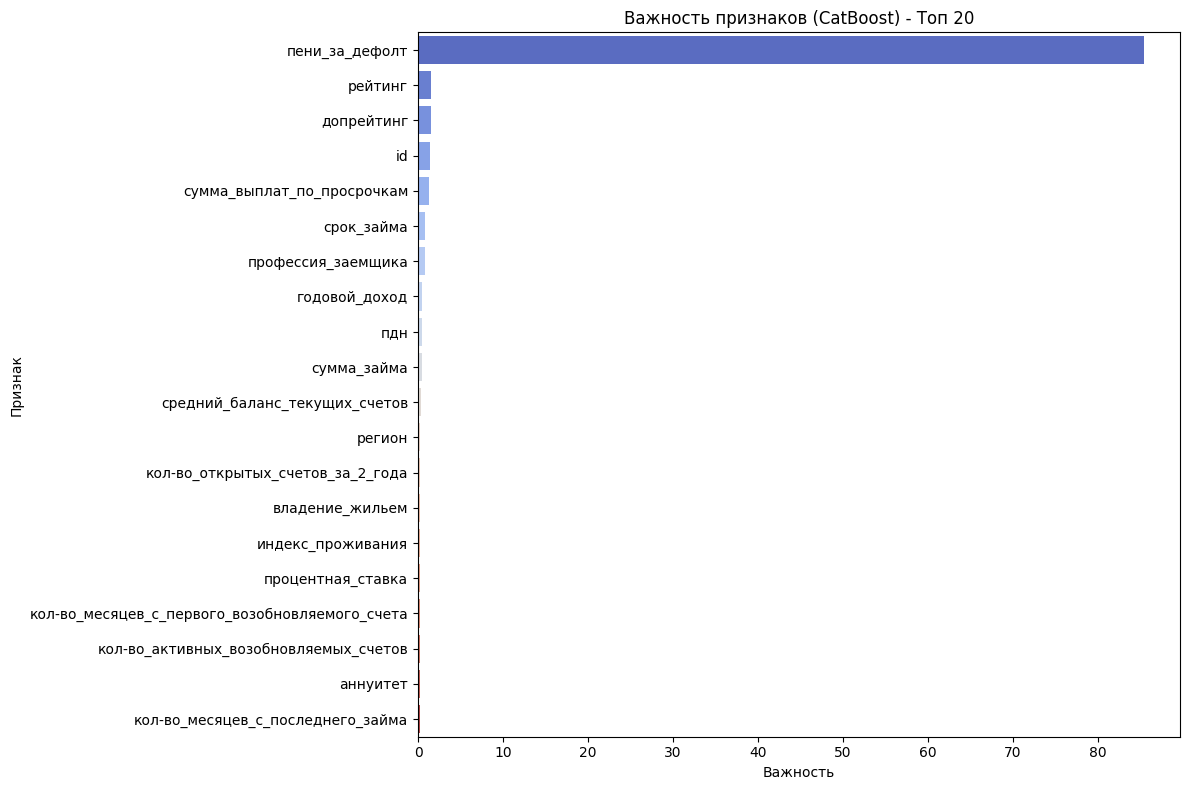

3210

In [109]:
# визуализация

fig = plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance_cat.head(20),
    palette='coolwarm'
)
plt.title('Важность признаков (CatBoost) - Топ 20')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()
plt.close(fig)
del fig
gc.collect()

In [111]:
# для очистки памяти удалим специально созданные переменные и соберем мусор

del train_base2, test_base2, X_b, y_b, X_train_b, X_valid_b, y_train_b, y_valid_b, cat_features, train_pool, valid_pool, y_valid_pred_cat, valid_roc_auc_cat, test_pred_cat, submission_cat, feature_importance_cat, feature_names_cat
gc.collect()

6930

### Вывод по CatBoost

Модель CatBoost без проблем обучилась на небрежно обработанных данных.

ROC-AUC на:

- валидационной выборке **0.8742**
- тестовой выборке **0.76999** (инфо с платформы соревнования codabench)

Подбора гиперпараметров не было. Была применена ранняя остановка во избежание переобучения, но она не сработала. На тестовой выборке метрика чуть-чуть лучше, чем у LightGBM, но в целом также обвалилась. Модель здорово переобучена. Также за счет отсутствия кодирования категориальных данных время обучения у CatBoost значительное - порядка 1ч 20 мин.

Получена информация о важных признаках для модели CatBoost. Из топ-10 важных признаков **7** из них также перекликаются с признаками, выявленными при анализе корреляций с целевой переменной и с признаками, которые выделила для себя LightGBM. Это:

- пени_за_дефолт
- допрейтинг
- сумма_выплат_по_просрочкам
- рейтинг
- срок_займа
- профессия_заемщика
- процентная_ставка

 + аналогично LightGBM:
- id
- годовой_доход
- пдн

Признак 'пени_за_дефолт' подтвердил свою исключительную важность для определения целевой переменной. Модель ориентируется только на него, и на тестовых данных не способна хорошо классифицировать итоговый статус займа.

Для дальнейшей работы выбрана модель CatBoost из-за своих преимуществ в отсутствии необходимости:
- кодировки категориальных признаков
- нормализации числовых данных
- уменьшения размерности признаков

Она почти всегда позволяет добиться максимального результа на сырых данных.

# Обработка данных

Поскольку мы не располагаем информацией о природе признака 'пени_за_дефолт' и попытки за кадром восстановить его в тестовой выборке не увенчались значительным успехом, попробуем просто удалить его и посмотреть как обучится модель в таком случае.

In [115]:
# удаляем полностью пустой столбец признака 'дата_следующей_выплаты', а также столбец 'пени_за_дефолт', который заполнен только в train

train_processed = train.drop(columns=['дата_следующей_выплаты', 'пени_за_дефолт'], errors='ignore')
test_processed = test.drop(columns=['дата_следующей_выплаты', 'пени_за_дефолт'], errors='ignore')

 Можно было бы удалить также столбцы 'платежный_график', 'особая_ситуация', 'индекс_проживания', 'код_политики' и др.подобные, которые заполнены одним-единственным значением, либо странным значением (индекс). Но удаление даже малозначимых столбцов (на взгляд автора) приводит к ухудшению метрики и на валидационной (примерно на 0.005-0.007) и на тестовой выборках. CatBoost всё же находит какие-то полезные зависимости в них. А поскольку борьба на платформе идет за тысячные и десятитысячные знаки после запятой, поэтому все оставляем.

In [116]:
# функция для заполнения пропусков в группе признаков 'совокупный...' при типе займа 'Индивидуальный'

def fill_aggregate_columns_na(df):
    df_filled = df.copy()
    mask_individual = (df_filled['тип_займа'] == 'Индивидуальный')

    # заполняем только пропуски в каждом столбце
    if 'совокупный_доход_заемщиков' in df_filled.columns:
        df_filled.loc[mask_individual & df_filled['совокупный_доход_заемщиков'].isna(),
                    'совокупный_доход_заемщиков'] = 0.0

    if 'совокупный_пдн_заемщиков' in df_filled.columns:
        df_filled.loc[mask_individual & df_filled['совокупный_пдн_заемщиков'].isna(),
                    'совокупный_пдн_заемщиков'] = 0.0

    if 'совокупный_статус_подтверждения_доходов_заемщиков' in df_filled.columns:
        df_filled.loc[mask_individual & df_filled['совокупный_статус_подтверждения_доходов_заемщиков'].isna(),
                    'совокупный_статус_подтверждения_доходов_заемщиков'] = 'Не требуется'

    # явное преобразование типов (на всякий случай)
    df_filled['совокупный_доход_заемщиков'] = df_filled['совокупный_доход_заемщиков'].astype('float64')
    df_filled['совокупный_пдн_заемщиков'] = df_filled['совокупный_пдн_заемщиков'].astype('float64')
    df_filled['совокупный_статус_подтверждения_доходов_заемщиков'] = \
        df_filled['совокупный_статус_подтверждения_доходов_заемщиков'].astype('object')

    return df_filled

In [117]:
# применяем функцию

train_processed = fill_aggregate_columns_na(train_processed)
test_processed = fill_aggregate_columns_na(test_processed)

In [118]:
# функция для заполнения пропусков в столбце 'профессия_заемщика' значением 'unknown'

def fill_missing_profession(df):
    df_filled = df.copy()
    # заполняем только пропуски
    if 'профессия_заемщика' in df_filled.columns:
        df_filled['профессия_заемщика'] = df_filled['профессия_заемщика'].fillna('unknown')
        # явное преобразование типа (на всякий случай)
        df_filled['профессия_заемщика'] = df_filled['профессия_заемщика'].astype('object')

    return df_filled

In [119]:
# применяем функцию

train_processed = fill_missing_profession(train_processed)
test_processed = fill_missing_profession(test_processed)

In [120]:
# функция для заполнения пропусков нулями

def fill_na_with_zero(df):
    # список столбцов для обработки
    columns_to_fill = [
        'кол-во_месяцев_с_последней_просрочки',
        'кол-во_месяцев_с_последнего_займа',
        'кол-во_месяцев_с_последнего_нарушения',
        'общая_сумма_на_счетах',
        'кол-во_открытых_счетов_за_полгода',
        'кол-во_текущих_аннуитетных_счетов',
        'кол-во_аннуитетных_счетов_за_год',
        'кол-во_аннуитетных_счетов_за_2_года',
        'кол-во_месяцев_с_посл_аннуитетного_счета',
        'текущий_баланс_по_аннуитетным_счетам',
        'соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам',
        'кол-во_возоб_счетов_за_год',
        'кол-во_возоб_счетов_за_2_года',
        'макс_баланс_по_возоб_счетам',
        'соотношение_баланса_к_лимиту_общее',
        'общий_лимит_по_возоб_счету',
        'кол-во_финансовых_запросов',
        'кол-во_финансовых_операций',
        'кол-во_заявок_на_кредит_за_год',
        'кол-во_открытых_счетов_за_2_года',
        'средний_баланс_текущих_счетов',
        'суммарная_доступная_сумма_займа_по_картам',
        'соотношение_баланса_к_лимиту_по_картам',
        'кол-во_списаний_за_год',
        'кол-во_месяцев_с_первого_аннуитетного_счета',
        'кол-во_месяцев_с_первого_возобновляемого_счета',
        'кол-во_месяцев_с_последнего_возобновляемого_счета',
        'кол-во_месяцев_с_последнего_счета',
        'кол-во_ипотек',
        'кол-во_месяцев_с_последней_карты',
        'кол-во_мес_с_последней_задолженности_по_карте',
        'кол-во_мес_с_последней_заявки',
        'кол-во_мес_с_последней_задолженности_по_возобновляемому_счету',
        'кол-во_счетов_с_просрочкой_4_мес',
        'кол-во_активных_карт',
        'кол-во_активных_возобновляемых_счетов',
        'кол-во_карт_без_нарушений',
        'кол-во_карт',
        'кол-во_аннуитетных_счетов',
        'кол-во_открытых_возобновляемых_счетов',
        'кол-во_возобновляемых_счетов',
        'кол-во_возобновляемых_счетов_с_балансом_более_0',
        'кол-во_счетов_без_нарушений',
        'кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес',
        'кол-во_счетов_с_акт_просрочкой_1_мес',
        'кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года',
        'кол-во_счетов_за_посл_год',
        'процент_счетов_без_просрочек',
        'процент_счетов_прев_75_лимита',
        'кол-во_публ_банкротств',
        'кол-во_залогов',
        'кредитный_лимит',
        'кредитный_баланс_без_ипотеки',
        'лимит_по_картам',
        'лимит_по_аннуитетным_счетам',
        'кредитный_баланс_по_возоб_счетам'
    ]

    df_filled = df.copy()

    # заполняем только пропуски с сохранением типов
    for col in columns_to_fill:
        if col in df_filled.columns:
            col_dtype = df_filled[col].dtype # исходный тип данных столбца
            df_filled[col] = df_filled[col].fillna(0)
            df_filled[col] = df_filled[col].astype(col_dtype) # явно присваиваем исх.тип данных

    return df_filled

In [121]:
# применяем функцию

train_processed = fill_na_with_zero(train_processed)
test_processed = fill_na_with_zero(test_processed)

In [122]:
# оставшиеся пропуски заполняем модами в категориальрных столбцах и медианами в числовых

def preprocess_data_rest(df):

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    return df

In [123]:
# применяем функцию

train_processed = preprocess_data_rest(train_processed)
test_processed = preprocess_data_rest(test_processed)

In [125]:
# для очистки памяти удаляем ненужные переменные и соберем мусор

del train, test
gc.collect()

3014

# Обучение

## Обучение CatBoost - на обработанных данных

Обучим снова модель CatBoost на обработанных данных и, главное, без признака 'пени_за_дефолт'

In [127]:
# подготовка данных

X = train_processed.drop(columns=['итоговый_статус_займа'])
y = train_processed['итоговый_статус_займа']

In [128]:
# категориальные признаки

cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [129]:
# разделение на train/valid (со стратификацией)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [130]:
# создаем Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

In [131]:
# параметры CatBoost

params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': RANDOM_STATE,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 100,
    'auto_class_weights': 'Balanced'
    #'task_type':'GPU'
}

In [132]:
# обучение модели

model = CatBoostClassifier(**params)

model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=100
)

0:	test: 0.7259724	best: 0.7259724 (0)	total: 5.71s	remaining: 1h 35m 3s
100:	test: 0.7525244	best: 0.7525244 (100)	total: 7m 31s	remaining: 1h 7m 2s
200:	test: 0.7604326	best: 0.7604326 (200)	total: 14m 58s	remaining: 59m 30s
300:	test: 0.7639782	best: 0.7639782 (300)	total: 22m 22s	remaining: 51m 58s
400:	test: 0.7666157	best: 0.7666157 (400)	total: 29m 45s	remaining: 44m 27s
500:	test: 0.7682334	best: 0.7682334 (500)	total: 37m 28s	remaining: 37m 19s
600:	test: 0.7692983	best: 0.7692983 (600)	total: 44m 50s	remaining: 29m 46s
700:	test: 0.7700393	best: 0.7700393 (700)	total: 52m 21s	remaining: 22m 20s
800:	test: 0.7705739	best: 0.7705739 (800)	total: 59m 53s	remaining: 14m 52s
900:	test: 0.7710301	best: 0.7710301 (900)	total: 1h 7m 22s	remaining: 7m 24s
999:	test: 0.7714519	best: 0.7714519 (999)	total: 1h 14m 36s	remaining: 0us

bestTest = 0.7714518801
bestIteration = 999



In [133]:
# проверка на валидации на CPU

valid_preds = model.predict_proba(X_valid)[:, 1]
print(f'ROC-AUC на валидации: {roc_auc_score(y_valid, valid_preds):.4f}')

ROC-AUC на валидации: 0.7715


Метрика ожидаемо упала, но она стала близка к той, что была ранее на тестовых данных (по инфо с платформы Codabench).

In [134]:
# предсказания на test

test_probs = model.predict_proba(test_processed)[:, 1]

In [135]:
# выгрузка submission

submission = pd.DataFrame({'ID': test_processed['id'], 'Proba': test_probs})
submission.to_csv('submission.csv', index=False)

In [136]:
# получаем важность признаков

feature_importance = model.get_feature_importance()
feature_names = X_train.columns

In [137]:
# создаем табличку

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

In [138]:
# выводим топ-15

print("Топ-15 важных признаков:")
display(feature_importance.head(15))

Топ-15 важных признаков:


,Feature,Importance
5,рейтинг,16.14
38,сумма_выплат_по_просрочкам,13.99
6,допрейтинг,9.88
0,id,6.82
7,профессия_заемщика,4.96
2,срок_займа,4.71
19,пдн,2.87
1,сумма_займа,2.63
10,годовой_доход,2.34
66,кол-во_открытых_счетов_за_2_года,2.21


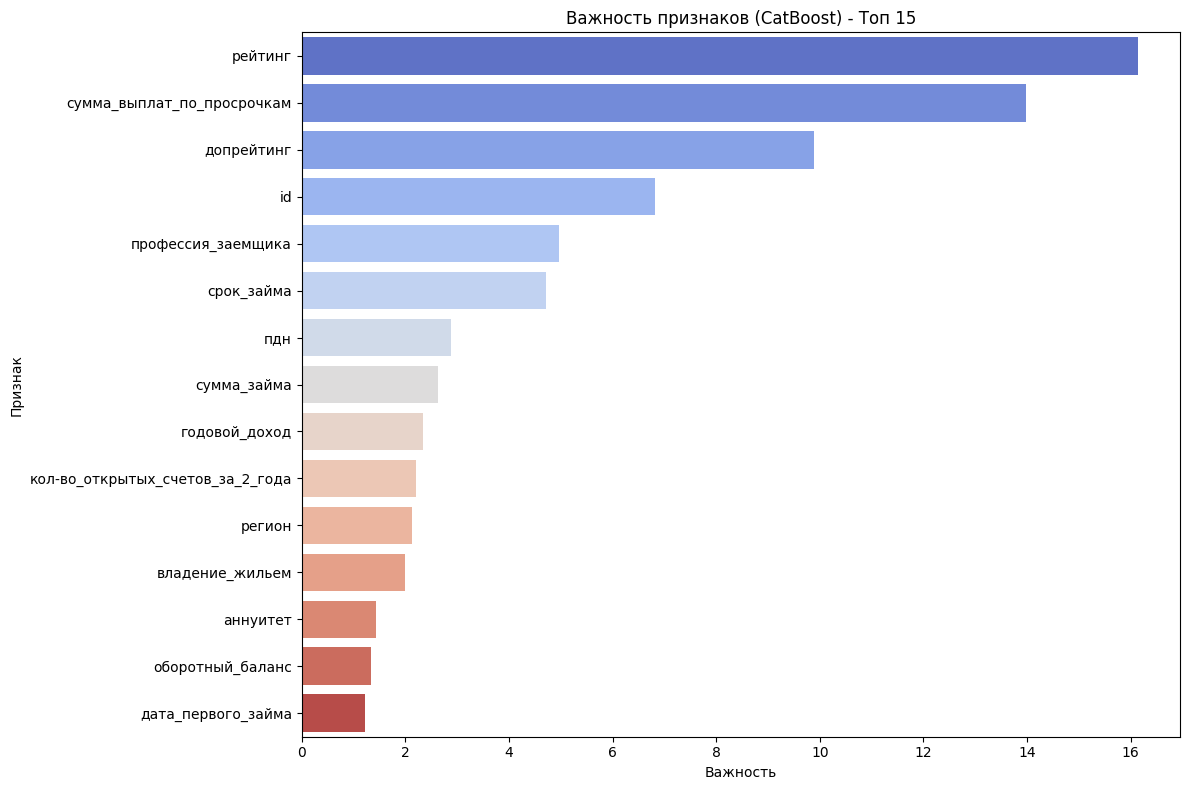

191

In [139]:
# визуализация

fig = plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance.head(15),
    palette='coolwarm'
)
plt.title('Важность признаков (CatBoost) - Топ 15')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()
plt.close(fig)
del fig
gc.collect()

In [141]:
# для очистки памяти удаляем ненужное

del valid_preds, test_probs, submission, feature_importance
gc.collect()

5770

Удаление столбца 'пени_за_дефолт' положительно сказалось на обучении модели. Она выдает качество на валидации соразмерное тому, что изначально выдали бэйзлайн-модели на тестовой выборке.

Важность признаков перераспределилась на оставшиеся в топе-10 признаках.

## CatBoost-2

Оптимизация параметров обучения модели с помощью библиотеки Optuna за кадром не принесла явного успеха. Оптимизация происходила на gpu и заняла час, сохраненная лучшая модель при этом выдала сомнительные результаты. Перезапускать оптимизацию на cpu займет не менее 8-10 часов, поэтому не считаю целесообразным включать её в проект. Тем не менее во всех оптимизациях прослеживалась тенденция к увеличению количества итераций и скорости обучения. Ориентируясь на это знание, увеличила итерации с 1000 до 1400 и скорость обучения с 0.05 до 0.1.

In [142]:
# параметры CatBoost

params = {
    'iterations': 1400,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': RANDOM_STATE,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 100,
    'auto_class_weights': 'Balanced'
    #'task_type':'GPU'
}

In [143]:
# обучение модели

model_2 = CatBoostClassifier(**params)

model_2.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=100
)

0:	test: 0.7259724	best: 0.7259724 (0)	total: 4.67s	remaining: 1h 48m 50s
100:	test: 0.7601330	best: 0.7601330 (100)	total: 7m 30s	remaining: 1h 36m 31s
200:	test: 0.7666803	best: 0.7666803 (200)	total: 15m 1s	remaining: 1h 29m 39s
300:	test: 0.7689775	best: 0.7689775 (300)	total: 22m 36s	remaining: 1h 22m 33s
400:	test: 0.7701903	best: 0.7701903 (400)	total: 30m 6s	remaining: 1h 15m 1s
500:	test: 0.7709974	best: 0.7709974 (500)	total: 37m 40s	remaining: 1h 7m 35s
600:	test: 0.7715129	best: 0.7715129 (600)	total: 45m 1s	remaining: 59m 52s
700:	test: 0.7718657	best: 0.7718657 (700)	total: 52m 38s	remaining: 52m 29s
800:	test: 0.7721619	best: 0.7721692 (796)	total: 1h 3s	remaining: 44m 54s
900:	test: 0.7723721	best: 0.7723797 (898)	total: 1h 7m 28s	remaining: 37m 22s
1000:	test: 0.7725276	best: 0.7725276 (1000)	total: 1h 14m 58s	remaining: 29m 53s
1100:	test: 0.7726535	best: 0.7726568 (1099)	total: 1h 22m 20s	remaining: 22m 21s
Stopped by overfitting detector  (50 iterations wait)

bestT

In [144]:
# проверка на валидации на CPU

valid_preds_2 = model_2.predict_proba(X_valid)[:, 1]
print(f'ROC-AUC на валидации: {roc_auc_score(y_valid, valid_preds_2):.4f}')

ROC-AUC на валидации: 0.7727


Метрика на валидации совсем немного поднялась - с 0.7715 до 0.7727. Но прорыва опять не случилось - десятые и сотые доли не изменились.

In [145]:
# предсказания на test

test_probs_2 = model_2.predict_proba(test_processed)[:, 1]

In [146]:
# выгрузка submission

submission = pd.DataFrame({'ID': test_processed['id'], 'Proba': test_probs_2})
submission.to_csv('submission.csv', index=False)

### Важность признаков CatBoost-2

In [147]:
# получаем важность признаков

feature_importance = model_2.get_feature_importance()
feature_names = X_train.columns

In [148]:
# создаем табличку

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

In [149]:
# выводим топ-15

print("Топ-15 важных признаков:")
display(feature_importance.head(15))

Топ-15 важных признаков:


,Feature,Importance
5,рейтинг,13.20
38,сумма_выплат_по_просрочкам,12.02
6,допрейтинг,6.55
0,id,6.37
7,профессия_заемщика,4.58
2,срок_займа,4.03
19,пдн,2.84
10,годовой_доход,2.56
1,сумма_займа,2.54
9,владение_жильем,1.96


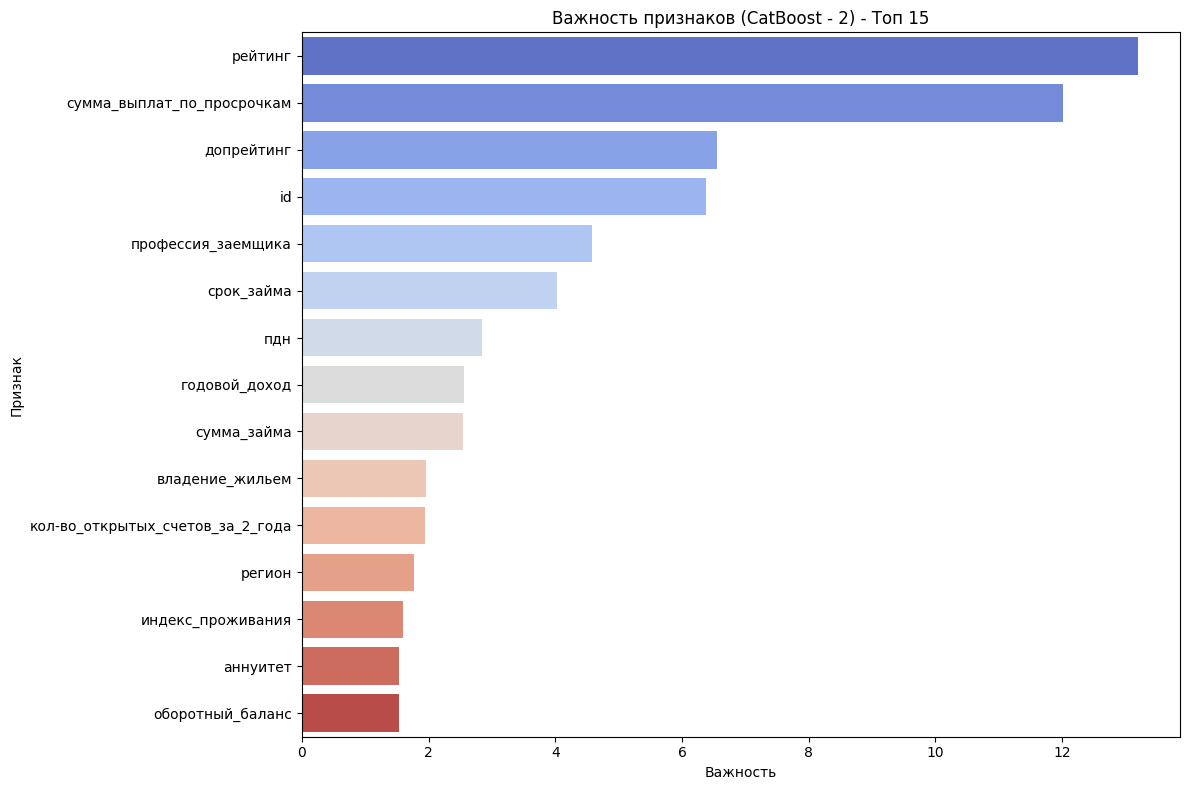

185

In [150]:
# визуализация

fig = plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance.head(15),
    palette='coolwarm'
)
plt.title('Важность признаков (CatBoost - 2) - Топ 15')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()
plt.close(fig)
del fig
gc.collect()

In [152]:
# удаляем ненужные переменные и собираем мусор

del valid_preds_2, test_probs_2, submission, X, y, cat_features, X_train, X_valid, y_train, y_valid, train_pool, valid_pool, feature_importance
gc.collect()

5564

Небольшая оптимизация параметров обучения модели позволила немного улучшить метрику на валидации. При этом сработала ранняя остановка во избежание переобучения. Важность признаков не изменилась.

## Feature engineering

Поскольку подбор параметров обучения не дал кардинального улучшения метрики, попробуем такой подход как Feature Engineering и создадим несколько признаков из комбинации важных для CatBoost.

Создадим признак для придания веса значениям допрейтинга на основе частоты встречаемости соответственно каждого значения допрейтинга в обучающей выборке, с преобразованием категорий в числа от 0 до 1, где 1 — самая частая категория. Для тестовой выборки будем использовать те же веса, а для новых категорий 0.

In [154]:
# создадим признак на основе частот категорий допрейтинга

category_freq = train_processed['допрейтинг'].value_counts(normalize=True).to_dict()

In [155]:
# применим к train и test

train_processed['допрейтинг_вес'] = train_processed['допрейтинг'].map(category_freq)
test_processed['допрейтинг_вес'] = test_processed['допрейтинг'].map(category_freq).fillna(0)  # новые категории получают 0

/tmp/ipython-input-2903288236.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_processed['допрейтинг_вес'] = train_processed['допрейтинг'].map(category_freq)
/tmp/ipython-input-2903288236.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_processed['допрейтинг_вес'] = test_processed['допрейтинг'].map(category_freq).fillna(0)  # новые категории получают 0


Создадим новый признак логарифм суммы выплат по просрочкам. Применим логарифмирование к сумме просрочек после добавления 1, чтобы избежать log(0).

In [156]:
# создадим признак с логарифмом суммой просрочек (для уменьшения влияния выбросов)

train_processed['log_просрочки'] = np.log1p(train_processed['сумма_выплат_по_просрочкам'])
test_processed['log_просрочки'] = np.log1p(test_processed['сумма_выплат_по_просрочкам'])

/tmp/ipython-input-1618393864.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_processed['log_просрочки'] = np.log1p(train_processed['сумма_выплат_по_просрочкам'])
/tmp/ipython-input-1618393864.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_processed['log_просрочки'] = np.log1p(test_processed['сумма_выплат_по_просрочкам'])


Создадим признак взвешенный риск на основе комбинации веса допрейтинга и логарифма просрочек. Умножим частотный вес допрейтинга на логарифм суммы просрочек.

In [157]:
# создадим признак из комбинации веса допрейтинга и логарифма суммы просрочек

train_processed['взвешенный_риск'] = train_processed['допрейтинг_вес'] * train_processed['log_просрочки']
test_processed['взвешенный_риск'] = test_processed['допрейтинг_вес'] * test_processed['log_просрочки']

/tmp/ipython-input-834342351.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_processed['взвешенный_риск'] = train_processed['допрейтинг_вес'] * train_processed['log_просрочки']
/tmp/ipython-input-834342351.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_processed['взвешенный_риск'] = test_processed['допрейтинг_вес'] * test_processed['log_просрочки']


Создадим признак высокий риск, если сочетаются хотя бы один из самых плохих допрейтингов и выплаты по просрочкам. Обозначим модели высокие риски явно.

In [158]:
# создадим признак с меткой высокого риска (2 самых плохих допрейтинга: Е или Ж + выплаты по просрочкам)

train_processed['высокий_риск'] = ((train_processed['допрейтинг'].isin(['Е', 'Ж'])) &
                       (train_processed['сумма_выплат_по_просрочкам'] > 0)).astype(int)
test_processed['высокий_риск'] = ((test_processed['допрейтинг'].isin(['Е', 'Ж'])) &
                      (test_processed['сумма_выплат_по_просрочкам'] > 0)).astype(int)

/tmp/ipython-input-2105840663.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_processed['высокий_риск'] = ((train_processed['допрейтинг'].isin(['Е', 'Ж'])) &
/tmp/ipython-input-2105840663.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_processed['высокий_риск'] = ((test_processed['допрейтинг'].isin(['Е', 'Ж'])) &


In [159]:
train_processed.head(3)

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,итоговый_статус_займа,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита,допрейтинг_вес,log_просрочки,взвешенный_риск,высокий_риск
0,68355089,1235000.00,3 года,11.99,41014.00,В,В1,инженер,10+ лет,ИПОТЕКА,1300000.00,Не подтвержден,0,4,n,0.90,мелкий_бизнес,0,577.00,Новгородская область,16.06,Нет,Нет,1.00,1345311.54,0.77,12-1999,715.00,719.00,4.00,6.00,0.00,22.00,0.00,21470.00,19.20,38.00,а,0.00,0.00,5,0.00,0.00,1.00,Индивидуальный,0.00,0.00,Не требуется,0.00,0.00,12213,10219800.00,1.00,1.00,0.00,1.00,19.00,900250.00,73.00,2.00,3.00,6472.00,29.00,5590000.00,0.00,0.00,6.00,4.00,486650.00,2891500.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,0.00,0.00,6.00,0.00,5.00,5.00,13.00,17.00,6.00,20.00,27.00,5.00,22.00,0.00,0.00,0.00,2.00,97.40,7.70,0.00,0.00,15700850.00,1973750.00,3965000.00,1233350.00,0.00,Нет,Наличные,0.06,0.00,0.00,0
1,68341763,1000000.00,5 лет,10.78,21633.00,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,1260000.00,Не подтвержден,0,2,n,0.49,улучшение_жилищных_условий,0,605.00,Республика Татарстан,10.78,Нет,Нет,0.00,1345311.54,0.23,8-2000,695.00,699.00,0.00,0.00,0.00,6.00,0.00,7869.00,56.20,18.00,а,0.00,0.00,1,0.00,0.00,1.00,Совм

In [160]:
test_processed.head(3)

,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита,допрейтинг_вес,log_просрочки,взвешенный_риск,высокий_риск
0,85540387,450000.00,3 года,9.49,14413.00,Б,Б2,обслуживание клиентов,10+ лет,ИПОТЕКА,840000.00,Не подтвержден,4,n,0.46,консолидация_долга,0,601.00,Республика Татарстан,19.09,Нет,Да,0.00,1345311.54,0.81,6-1995,740.00,744.00,0.00,0.00,0.00,11.00,0.00,7735.00,34.10,20.00,а,0.00,0.00,1,0.00,0.00,1.00,Индивидуальный,0.00,0.00,Не требуется,0.00,0.00,92843,3111700.00,0.00,2.00,1.00,2.00,10.00,793850.00,78.00,0.00,1.00,2594.00,55.00,1135000.00,1.00,1.00,2.00,3.00,282900.00,395700.00,45.40,0.00,0.00,112.00,253.00,17.00,10.00,2.00,17.00,0.00,10.00,0.00,0.00,3.00,5.00,4.00,6.00,7.00,8.00,11.00,5.00,11.00,0.00,0.00,0.00,1.00,100.00,75.00,0.00,0.00,4282850.00,1180600.00,725000.00,1022000.00,0.00,Нет,Наличные,0.06,0.00,0.00,0
1,28112500,400000.00,3 года,6.03,12174.50,А,А1,помощник по правовым вопросам,5 лет,АРЕНДА,1520000.00,Не подтвержден,4,n,0.01,консолидация_долга,0,112.00,Новосибирская область,20.42,Нет,Нет,0.00,1345311.54,0.73,12-1997,710.00,714.00,0.00,0.00,0.00,14.00,0.00,23650.00,78.60,28.00,б,0.00,0.00,1,0.00,0.00,1.00,Индивидуальный,

Все новые признаки успешно добавились.

### Подготовка данных

In [161]:
# подготовка данных

X = train_processed.drop(columns=['итоговый_статус_займа'])
y = train_processed['итоговый_статус_займа']

In [162]:
# категориальные признаки

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [163]:
# разделение на train/valid (со стратификацией)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

### Обучение CatBoost - 3

In [164]:
# создаем Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

In [165]:
# параметры CatBoost

params = {
    'iterations': 1400,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': RANDOM_STATE,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 100,
    'auto_class_weights': 'Balanced'
    #'task_type':'GPU'
}

In [166]:
# обучение модели

model_3 = CatBoostClassifier(**params)

model_3.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=100
)

0:	test: 0.7252325	best: 0.7252325 (0)	total: 3.92s	remaining: 1h 31m 19s
100:	test: 0.7612758	best: 0.7612758 (100)	total: 7m 37s	remaining: 1h 38m 10s
200:	test: 0.7668732	best: 0.7668732 (200)	total: 15m 6s	remaining: 1h 30m 5s
300:	test: 0.7694891	best: 0.7694891 (300)	total: 22m 41s	remaining: 1h 22m 52s
400:	test: 0.7707566	best: 0.7707566 (400)	total: 30m 13s	remaining: 1h 15m 19s
500:	test: 0.7716162	best: 0.7716162 (500)	total: 38m 4s	remaining: 1h 8m 19s
600:	test: 0.7720828	best: 0.7720828 (600)	total: 45m 33s	remaining: 1h 34s
700:	test: 0.7723868	best: 0.7723868 (700)	total: 53m 6s	remaining: 52m 57s
800:	test: 0.7726375	best: 0.7726375 (800)	total: 1h 38s	remaining: 45m 20s
900:	test: 0.7728323	best: 0.7728432 (896)	total: 1h 8m 12s	remaining: 37m 46s
1000:	test: 0.7729863	best: 0.7729939 (998)	total: 1h 15m 35s	remaining: 30m 7s
1100:	test: 0.7730982	best: 0.7731007 (1073)	total: 1h 22m 57s	remaining: 22m 31s
1200:	test: 0.7731468	best: 0.7731622 (1191)	total: 1h 30m 29s

In [167]:
# проверка на валидации

valid_preds_3 = model_3.predict_proba(X_valid)[:, 1]
print(f'ROC-AUC на валидации: {roc_auc_score(y_valid, valid_preds_3):.4f}')

ROC-AUC на валидации: 0.7733


Пусть и небольшое, но снова стабильное улучшение метрики на валидации, с 0.7727 до 0.7733, при этом ранней остановки не было.

In [168]:
# предсказания на test

test_probs_3 = model_3.predict_proba(test_processed)[:, 1]

In [169]:
# выгрузка submission

submission = pd.DataFrame({'ID': test_processed['id'], 'Proba': test_probs_3})
submission.to_csv('submission.csv', index=False)

Эта финальная лучшая модель на тестовых данных показала ROC-AUC 0.7752 (данные с платформы Codabench). Переобучения модели model-3 (CatBoost) не выявлено.

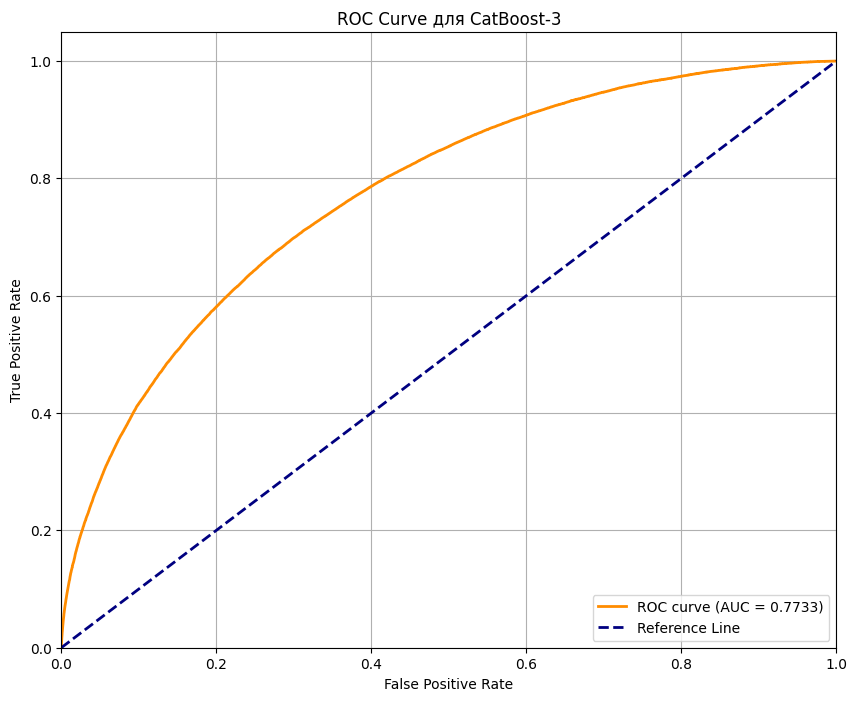

3242

In [177]:
# построим ROC-кривую для лучшей модели CatBoost-3 на валидации

fpr, tpr, thresholds = roc_curve(y_valid, valid_preds_3)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Reference Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для CatBoost-3')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
plt.close(fig)
del fig
gc.collect()

Полученное качество классификатора CatBoost-3 скорее удовлетворительное (площадь под кривой не превысила 0.8). Идеальный классификатор стремится в верхний левый угол и означает высокую чувствительность к истинно положительным классам и низкую частоту ложных срабатываний. CatBoost - мощная бустинговая моедль - позволила получить хорошо откалиброванные вероятности, которые плавно меняясь, создали гладкую кривую. Этому способствовали и огромное количество данных (> 1 млн.строк, > 100 признаков). Модель показала стабильную хорошую работу.

 Но также остается и потенциал для улучшения модели в направлении feature engineering и оптимизации параметров обучения. Для работы с признаками нужно их подробное описание и источник возникновения, а для подбора параметров с помощью GridSearchCV требуются временные затраты, т.к. CatBoost долго обучается.

### Важность признаков СatBoost-3

In [172]:
# получаем важность признаков

feature_importance = model_3.get_feature_importance()
feature_names = X_train.columns

In [173]:
# создаем табличку

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

In [174]:
# выводим топ-15

print("Топ-15 важных признаков:")
display(feature_importance.head(15))

Топ-15 важных признаков:


,Feature,Importance
5,рейтинг,12.36
6,допрейтинг,7.00
0,id,6.33
7,профессия_заемщика,4.30
107,log_просрочки,3.68
2,срок_займа,3.50
108,взвешенный_риск,3.40
19,пдн,2.89
1,сумма_займа,2.75
10,годовой_доход,2.75


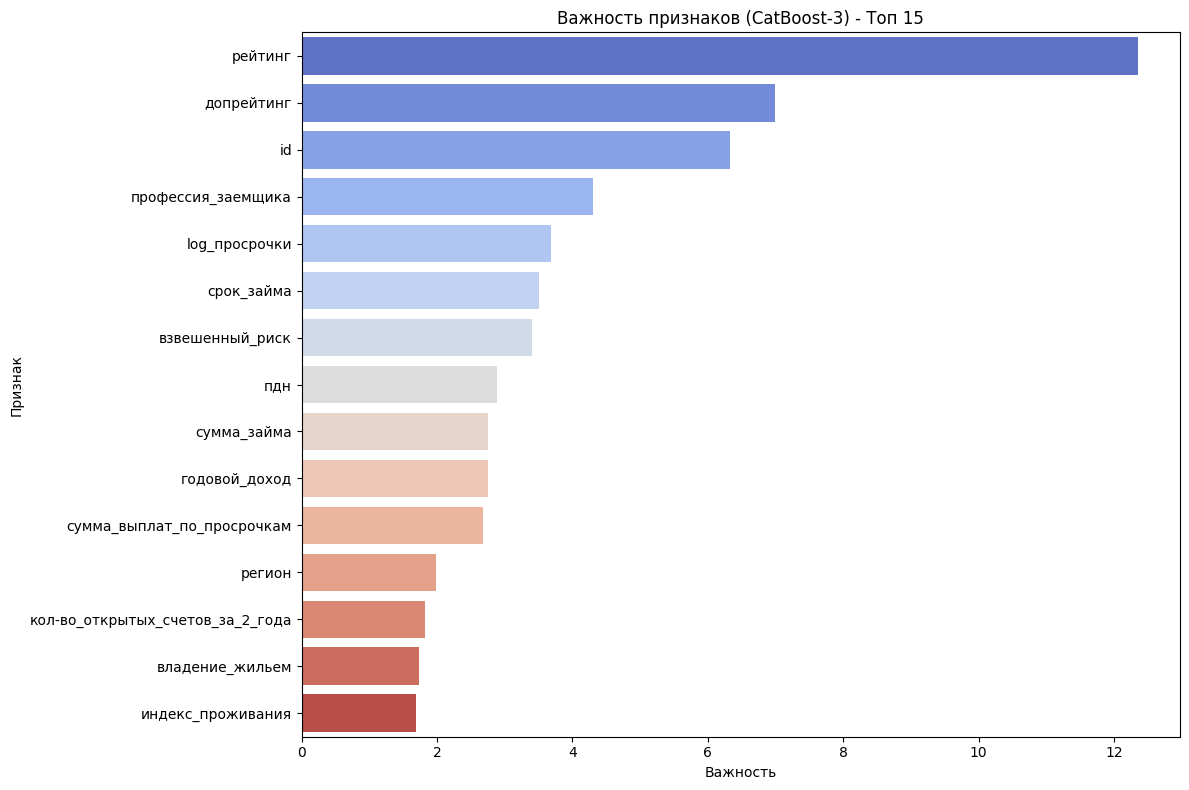

5610

In [175]:
# визуализация

fig = plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance.head(15),
    palette='coolwarm'
)
plt.title('Важность признаков (CatBoost-3) - Топ 15')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()
plt.close(fig)
del fig
gc.collect()

Новый созданный признак занял достойное 5-е место в топе-15 важных признаков для модели.

# Выводы и наблюдения по проекту "Кредитный скоринг"

- Организатором соревнования были предоставлены табличные данные в виде двух датасетов размерами 1 210 779 строк - train и 134 531 строка - test.

- Необходимо было обучить классификатор, наилучшим образом предсказывающий целевой признак 'итоговый_статус_займа' - выплачен '0' или не выплачен '1'.

- Из положительных моментов: в данных отсутствовали дубликаты, бесконечные значения и было лишь несколько отрицательных (природа которых осталась неясной).

- Проблемы, с которыми столкнулась при работе с данными:
   * пропуски и непонимание как их заполнять. В обучающих данных был один признак ('пени_за_дефолт'), который сильно коррелировал с целевой переменной и на которых модели обучались, показывая хорошее качество (порядка 0.85) на валидационной выборке. Но из-за отсутствия этого признака в тестовых данных качество классификации на тесте обваливалось.
   * из-за большого количества данных возникали проблемы с переполнением оперативной памяти в google colab (среда, в которой выполнялся проект), что не позволяло полностью перезапустить ноутбук в одной среде. Также по условиям соревнования нельзя было отделить EDA в отдельный ноутбук. Проблема решилась очисткой памяти после каждого этапа работ и удалением созданных переменных (финальный вариант укладывается в лимит 12GB).

- Попытки восстановить признак 'пени_за_дефолт'в тестовых данных не увенчались успехом.(ROC-AUC модели, обученной на классификацию этого признака, также был на уровне 0.75) Поэтому было принято решение удалить его из обучающей выборки.

- После чего модель показала хоть и удовлетворительное качество (0.76-0.77), зато примерно одинаковое и на валидационной выборке и на тестовой, что говорит об отсутствии переобучения.

- За день до окончания соревнования наткнулась на <a href="https://habr.com/ru/companies/vk/articles/746360/" title="Пугающее противостояние: утечка данных в машинном обучении" target="_blank">статью на Хабре</a>, в которой как раз говорится о том, что сильно коррелирующий с целевой переменной признак может оказаться вовсе не признаком, а следствием события, которое и определяет класс/значение целевой переменной. Так что удалить его из обучающей выборки было правильным решением. Возможно это были 'пени_за_дефолт' кредита, выплату которого мы и стремились предсказать, а не какого-то ранее выданного кредита/кредитов.

- Далее для улучшения метрики была применена оптимизация параметров обучения. С добавлением количества итераций и скорости обучения новая модель (CatBoost-2) позволила незначительно улучшить метрику на валидации, с 0.7715 до 0.7727.

- Также за кадром были применены (и в последствии отброшены) такие незначительные манипуляции к данным как:
    * перевод столбца с датой_первого_займа типа object в тип datetime
    * извлечение из него месяца первого займа и года первого займа в новые признаки
    * извлчение срока_займа типа object в число лет типа int и добавление в качестве нового признака
    * преобразование некоторых бинарных категориальных признаков типа object  в тип bool или int
    * добавление нескольких столбцов с отношениями признаков друг к другу (например, отношение суммы просрочек к доходу, суммы просрочек к сумме займа, суммы займа к годовому доходу, добавление категорий процентной ставки и др.)
  Все они неизменно ухудшали метрику в тысячных и десятитысячных знаках после запятой (а иногда и в сотых), принося шум в данные.

- После продления дедлайна был применен feature engineering исключительно на основе важных признаков для CatBoost.
    * Создан признак ['допрейтинг_вес'] для придания веса категориям допрейтинга на основе их частотности в обучающей выборке. Такое частотное кодирование сохраняет информацию о распределении категорий без использования целевой переменной, что исключает утечку данных.
    * Создан признак ['log_просрочки']. Логарифмирование уменьшает влияние выбросов и делает распределение более симметричным, что позволяет улучшить обучение модели.
    * Создан признак ['взвешенный_риск'] путем перемножения признаков ['допрейтинг_вес'] и ['log_просрочки']. Объединяет информацию о редкости (частотности) допрейтинга и размере выплаты по просрочкам.
    * Создан бинарный признак ['высокий_риск']: 1 - если допрейтинг Е или Ж + есть выплата по просрочкам и 0 - для остальных. Просто маркер для модели особо рисковых заемщиков.

- На обновленных данных была обучена третья модель CatBoost-3  на тех же параметрах, что и CatBoost-2 - для регистрации изменения метрики.
     ROC-AUC:
     - 0.7733 на валидационных данных
     - 0.7752 на тестовых данных (инфо с платформы Codabench)

     Переобучения не обнаружено.
    
- Новый признак 'log_просрочки' занял достойное 5-е место в рейтинге важных признаков для модели.

- Какого-то прорыва в улучшении качества классификации достичь с помощью генерации новых признаков не удалось. Хотя потенциал для дальнейшего улучшения есть.

# Итог конкурса "Кредитный скоринг"

- Задача конкурса по обучению классификатора, наилучшим образом (насколько это получилось у меня) предсказывающего целевую переменную - 'итоговый статус займа' - выполнена.

- Удалось достичь удовлетворительного качества предсказаний. Финальная модель CatBoost-3 показала ROC-AUC 0.7752 на тестовых данных (что позволило занять 8-е место на лидерборде (из 100)).

- Остался потенциал к улучшению качества классификации путем feature engineering и оптимизации параметров обучения.